In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
from sympy import (symbols, simplify)
from sympy.physics.mechanics import dynamicsymbols, init_vprinting
from sympy.physics.mechanics import Lagrangian, ReferenceFrame, Point, Particle,inertia, RigidBody, angular_momentum

In [3]:
from chords.symbolic import lagrange, diff_to_symb, SimpLagrangesMethod
from chords.numpy import unpack

In [4]:
init_vprinting()

### Symbolic Problem Modelling

In [5]:
m0, m1, m2, m3, m4, l0, l1, l2, l3, l4, t, g = symbols('m_0:5 l_0:5 t g')
I0, I1, I2, I3, I4, d0, d1, d2, d3, d4 = symbols('I_0:5 d_0:5')
q0, q1, q2, q3, q4 = dynamicsymbols('q_0:5')
m0, m1, m2, m3, m4, l0, l1, l2, l3, l4, t, g, I0, I1, I2, I3, I4, d0, d1, d2, d3, d4, q0, q1, q2, q3, q4

In [6]:
N_in = ReferenceFrame('N')
P0 = Point('P0')
P0.set_vel(N_in, 0)

N0 = N_in.orientnew('N0', 'Axis', [q0, N_in.z])
P1 = P0.locatenew('P1', l0 * N0.y)
P1.set_vel(N_in, P1.pos_from(P0).dt(N_in))
CM0 = P0.locatenew('CM0', (l0-d0) * N0.y)
CM0.set_vel(N_in, CM0.pos_from(P0).dt(N_in))
I_0 = inertia(N0, 0, 0, I0)
body0 = RigidBody('Stance_Tibia', CM0, N0, m0, (I_0,CM0))
body0.potential_energy = m0 * g * CM0.pos_from(P0).dot(N_in.y)


N1 = N_in.orientnew('N1', 'Axis', [q1, N_in.z])
P2 = P1.locatenew('P2', l1 * N1.y)
P2.set_vel(N_in, P2.pos_from(P0).dt(N_in))
CM1 = P1.locatenew('CM1', (l1-d1) * N1.y)
CM1.set_vel(N_in, CM1.pos_from(P0).dt(N_in))
I_1 = inertia(N1, 0, 0, I1)
body1 = RigidBody('Stance_Femur', CM1, N1, m1, (I_1,CM1))
body1.potential_energy = m1 * g * CM1.pos_from(P0).dot(N_in.y)


N2 = N_in.orientnew('N2', 'Axis', [q2, N_in.z])
P3 = P2.locatenew('P3', l2 * N2.y)
P3.set_vel(N_in, P3.pos_from(P0).dt(N_in))
CM2 = P2.locatenew('CM2', d2 * N2.y)
CM2.set_vel(N_in, CM2.pos_from(P0).dt(N_in))
I_2 = inertia(N2, 0, 0, I2)
body2 = RigidBody('Torso', CM2, N2, m2, (I_2,CM2))
body2.potential_energy = m2 * g * CM2.pos_from(P0).dot(N_in.y)


N3 = N_in.orientnew('N3', 'Axis', [q3, N_in.z])
P4 = P2.locatenew('P4', -l3 * N3.y)
P4.set_vel(N_in, P4.pos_from(P0).dt(N_in))
CM3 = P2.locatenew('CM3', -d3 * N3.y)
CM3.set_vel(N_in, CM3.pos_from(P0).dt(N_in))
I_3 = inertia(N3, 0, 0, I3)
body3 = RigidBody('Swing_Femur', CM3, N3, m3, (I_3,CM3))
body3.potential_energy = m3 * g * CM3.pos_from(P0).dot(N_in.y)


N4 = N_in.orientnew('N4', 'Axis', [q4, N_in.z])
P5 = P4.locatenew('P5', -l4 * N4.y)
P5.set_vel(N_in, P5.pos_from(P0).dt(N_in))
CM4 = P4.locatenew('CM4', -d4 * N4.y)
CM4.set_vel(N_in, CM4.pos_from(P0).dt(N_in))
I_4 = inertia(N4, 0, 0, I4)
body4 = RigidBody('Swing_Tibia', CM4, N4, m4, (I_4,CM4))
body4.potential_energy = m4 * g * CM4.pos_from(P0).dot(N_in.y)

In [7]:
Lag_simp = Lagrangian(N_in, body0, body1, body2, body3, body4)

In [8]:
from chords.symbolic import ImplicitLagrangesMethod

In [9]:
u0, u1, u2, u3, u4 = symbols('u_:5')
FL = [
    (N0, (u0-u1) * N_in.z),
    (N1, (u1-u2) * N_in.z),
    (N2, (u2-u3) * N_in.z),
    (N3, (u3-u4) * N_in.z),
    (N4, u4 * N_in.z)
]
LM_small = ImplicitLagrangesMethod(Lag_simp, [q0, q1, q2, q3, q4], forcelist=FL, frame=N_in)

_leq = LM_small.form_lagranges_equations()

impl_x = LM_small.implicit_dynamics_x

impl_q = LM_small.implicit_dynamics_q

from optibot.casadi import implicit_dynamic_q_to_casadi_function, implicit_dynamic_x_to_casadi_function
from optibot.symbolic import find_arguments

import casadi as cas

imp_dyn_x_f_cas = implicit_dynamic_x_to_casadi_function(impl_x, list(dynamicsymbols('x_0:10')), verbose=True)

imp_dyn_x_f_cas = implicit_dynamic_x_to_casadi_function(impl_x, 10, verbose=True)

imp_dyn_q_f_cas = implicit_dynamic_q_to_casadi_function(impl_q, list(LM_small.q), verbose=True)

Lag_num = Lag_simp.subs([
    [m0,3.2],
    [m1,6.8],
    [m2,20],
    [m3,6.8],
    [m4,3.2],
    [l0,0.4],
    [l1,0.4],
    [l2,0.625],
    [l3,0.4],
    [l4,0.4],
    [I0,0.93],
    [I1,1.08],
    [I2,2.22],
    [I3,1.08],
    [I4,0.93],
    [d0,1.128],
    [d1,0.163],
    [d2,0.2],
    [d3,0.163],
    [d4,0.128],
    [g, 9.81]
])
Lag_num

In [10]:
from chords.symbolic import diff_to_symb_expr

In [11]:
feet_x = P5.pos_from(P0).dot(N_in.x)
feet_x = diff_to_symb_expr(feet_x)
feet_x

In [12]:
feet_y = P5.pos_from(P0).dot(N_in.y)
feet_y = diff_to_symb_expr(feet_y)
feet_y

In [13]:
feet_y_vel = P5.vel(N_in).dot(N_in.y)   #pos_from(P0).dot(N_in.y)
feet_y_vel = diff_to_symb_expr(feet_y_vel)
feet_y_vel

In [14]:
cm_pos = m0*CM0.pos_from(P0)
cm_pos += m1*CM1.pos_from(P0)
cm_pos += m2*CM2.pos_from(P0)
cm_pos += m3*CM3.pos_from(P0)
cm_pos += m4*CM4.pos_from(P0)
cm_pos = cm_pos/(m0+m1+m2+m3+m4)

sys_CM = P0.locatenew('Sys_CM', cm_pos)
sys_CM_x = simplify(sys_CM.pos_from(P0).dot(N_in.x))
sys_CM_y = simplify(sys_CM.pos_from(P0).dot(N_in.y))

In [15]:
from sympy import lambdify

In [16]:
import casadi as cas
from chords.casadi import sympy2casadi

In [17]:
sym_x = dynamicsymbols('q_0:5')
sym_x = sym_x + [ii.diff() for ii in sym_x]
sym_x = [diff_to_symb(ii) for ii in sym_x]
sym_params = list(symbols('I_0:5 d_0:5 g l_0:2 l_3 m_0:5'))
sym_add_params = [symbols('l_4'),]
sym_vars = sym_x + sym_params + sym_add_params

print(len(sym_vars), sym_vars)

30 [q_0, q_1, q_2, q_3, q_4, v_0, v_1, v_2, v_3, v_4, I_0, I_1, I_2, I_3, I_4, d_0, d_1, d_2, d_3, d_4, g, l_0, l_1, l_3, m_0, m_1, m_2, m_3, m_4, l_4]


In [18]:
cas_x_args = cas.MX.sym("x", len(sym_x))
cas_params = cas.MX.sym("p", len(sym_params))
cas_add_params = cas.MX.sym("p_add", len(sym_add_params))
cas_all_vars = [cas_x_args[ii] for ii in range(len(sym_x))]
cas_all_vars += [cas_params[ii] for ii in range(len(sym_params))]
cas_all_vars += [cas_add_params[ii] for ii in range(len(sym_add_params))]
print(len(cas_all_vars), cas_all_vars)

30 [MX(x[0]), MX(x[1]), MX(x[2]), MX(x[3]), MX(x[4]), MX(x[5]), MX(x[6]), MX(x[7]), MX(x[8]), MX(x[9]), MX(p[0]), MX(p[1]), MX(p[2]), MX(p[3]), MX(p[4]), MX(p[5]), MX(p[6]), MX(p[7]), MX(p[8]), MX(p[9]), MX(p[10]), MX(p[11]), MX(p[12]), MX(p[13]), MX(p[14]), MX(p[15]), MX(p[16]), MX(p[17]), MX(p[18]), MX(p_add)]


In [19]:
_cas_expr_temp_x = sympy2casadi(feet_x, sym_vars, cas_all_vars)
feet_x_cas = cas.Function(
        "Feet_x",
        [cas_x_args, cas_params, cas_add_params],
        [_cas_expr_temp_x,],
        ["x", "params", "additional_params"],
        ["feet_x_position"],
    )

In [20]:
_cas_expr_temp_y = sympy2casadi(feet_y, sym_vars, cas_all_vars)
feet_y_cas = cas.Function(
        "Feet_y",
        [cas_x_args, cas_params, cas_add_params],
        [_cas_expr_temp_y,],
        ["x", "params", "additional_params"],
        ["feet_y_position"],
    )

In [21]:
_cas_expr_temp_y_vel = sympy2casadi(feet_y_vel, sym_vars, cas_all_vars)
feet_y_vel_cas = cas.Function(
        "Feet_y_vel",
        [cas_x_args, cas_params, cas_add_params],
        [_cas_expr_temp_y_vel,],
        ["x", "params", "additional_params"],
        ["feet_y_speed"],
    )

In [22]:
def simetric_cond_casadi(n = 5):
    x1 = cas.MX.sym('x_1', 2*n)
    x2 = cas.MX.sym('x_2', 2*n)
    cond = [x1[ii] - x2[n-1-ii] for ii in range(n)]
    cas_funcs = cas.horzcat(*cond)
    return cas.Function(
        "Sim_cond",
        [x1, x2],
        [cas_funcs,],
        ["x_1", "x2"],
        ["residue"],
    )

In [23]:
simetric_5_links = simetric_cond_casadi(5)
simetric_5_links

Function(Sim_cond:(x_1[10],x2[10])->(residue[1x5]) MXFunction)

In [24]:
bodies = [body0, body1, body2, body3, body4]
points_right = [P0, P1, P2, P2, P4]
points_left = [P5, P4, P2, P2, P1]
subs_key = list(zip(dynamicsymbols('q_0:5'),dynamicsymbols('q_p_0:5')))

impact_eqs = []
for ii in range(5):
    print('calculating eq', ii)
    print('\tleft side')
    left_side = angular_momentum(points_left[ii], N_in, *bodies[:5-ii]).dot(N_in.z)
    left_side = simplify(left_side)
    print('\tright side')
    right_side = angular_momentum(points_right[ii], N_in, *bodies[ii:]).dot(N_in.z)
    right_side = simplify(right_side).subs(subs_key)
    impact_eqs.append(left_side-right_side)
#impact_eqs

calculating eq 0
	left side
	right side
calculating eq 1
	left side
	right side
calculating eq 2
	left side
	right side
calculating eq 3
	left side
	right side
calculating eq 4
	left side
	right side


for ii in range(5):
    print(points_left[ii],bodies[:5-ii])
for ii in range(5):
    print(points_right[ii],bodies[ii:])

In [25]:
def impact_cond_casadi(eqs, x1_sym, x2_sym, sym_params, sym_add_params):
    x1_sym = [diff_to_symb(ii) for ii in x1_sym]
    x2_sym = [diff_to_symb(ii) for ii in x2_sym]
    eqs = [diff_to_symb_expr(ii) for ii in eqs]

    all_vars = x1_sym + x2_sym + sym_params + sym_add_params
    n = len(x1_sym)
    cas_x1 = cas.MX.sym('x_1', n)
    cas_x2 = cas.MX.sym('x_2', n)
    cas_params = cas.MX.sym("p", len(sym_params))
    cas_add_params = cas.MX.sym("p_add", len(sym_add_params))
    cas_all_vars = [cas_x1[ii] for ii in range(n)]
    cas_all_vars += [cas_x2[ii] for ii in range(n)]
    cas_all_vars += [cas_params[ii] for ii in range(len(sym_params))]
    cas_all_vars += [cas_add_params[ii] for ii in range(len(sym_add_params))]
    
    cas_funcs = []
    for function in eqs:
        cas_funcs.append(sympy2casadi(function, all_vars, cas_all_vars))
    cas_funcs = cas.horzcat(*cas_funcs)
    return cas.Function(
        "Sim_cond",
        [cas_x1, cas_x2, cas_params, cas_add_params],
        [cas_funcs,],
        ["x_1", "x2", 'params', 'additional_params'],
        ["residue"],
    )

In [26]:
sym_x = dynamicsymbols('q_0:5')
sym_x = sym_x + [ii.diff() for ii in sym_x]
subs_key = list(zip(dynamicsymbols('q_0:5'),dynamicsymbols('q_p_0:5')))
sym_x_2 = [ii.subs(subs_key) for ii in sym_x]
impact_cond_cas_f = impact_cond_casadi(impact_eqs, sym_x,  sym_x_2, sym_params, sym_add_params)

In [27]:
sys_cm_np = lambdify([sym_x, sym_params], [sys_CM_x, sys_CM_y],'numpy')

In [28]:
ang_mom_p0 = angular_momentum(P0, N_in, *bodies).dot(N_in.z)
ang_mom_p0_np = lambdify([sym_x, sym_params], ang_mom_p0,'numpy')

In [29]:
ang_mom_p5 = angular_momentum(P5, N_in, *bodies).dot(N_in.z)
ang_mom_p5_np = lambdify([sym_x, sym_params, sym_add_params], ang_mom_p5,'numpy')

In [30]:
P5_static = P5.locatenew('P5_static', 0 * N_in.y)
P5_static.set_vel(N_in, 0 * N_in.y)

In [31]:
ang_mom_p5_static = angular_momentum(P5_static, N_in, *bodies).dot(N_in.z)
ang_mom_p5_static_np = lambdify([sym_x, sym_params, sym_add_params], ang_mom_p5_static,'numpy')

In [32]:
from sympy.physics.mechanics import kinetic_energy, potential_energy

In [33]:
system_energy = potential_energy(*bodies) + kinetic_energy(N_in, *bodies)

In [34]:
system_energy_np = lambdify([sym_x, sym_params], system_energy,'numpy')

In [35]:
LM_small.form_lagranges_equations()
mass_matrix_np = lambdify([sym_x, sym_params], LM_small.mass_matrix,'numpy')

In [36]:
sym_u = symbols('u_:5')
#F_impl_np = lambdify([sym_x, sym_u, symbols('placeholder'), sym_params], LM_small.forcing,'numpy')
F_impl_np = lambdify([sym_x, sym_u, sym_params], LM_small.forcing,'numpy')

### Casadi optimization

In [37]:
I_0_n, I_1_n, I_2_n, I_3_n, I_4_n = 0.93, 1.08, 2.22, 1.08, 0.93
d_0_n, d_1_n, d_2_n, d_3_n, d_4_n = 0.128, 0.163, 0.2, 0.163, 0.128
g_n = 9.81
l_0_n, l_1_n, l_2_n, l_3_n, l_4_n = 0.4, 0.4, 0.625, 0.4, 0.4
m_0_n, m_1_n, m_2_n, m_3_n, m_4_n = 3.2, 6.8, 20, 6.8, 3.2
params = [
    I_0_n, I_1_n, I_2_n, I_3_n, I_4_n,
    d_0_n, d_1_n, d_2_n, d_3_n, d_4_n,
    g_n,
    l_0_n, l_1_n, l_3_n,
    m_0_n, m_1_n, m_2_n, m_3_n, m_4_n
]
additional_params = [l_4_n,]

In [38]:
from chords.opti import Opti_Problem
import time
from functools import lru_cache

In [39]:
@lru_cache(maxsize=None)
def five_link(scheme, N, ini_guess='lin', solve_repetitions = 1, t_end = 0.7, step_length = 0.5, verbose = False, silent = True):
    _opti = Opti_Problem(
        LM=LM_small,
        params = params,
        scheme = scheme,
        ini_guess= ini_guess,
        t_end = t_end,
        verbose=verbose,
        silent=silent,
    )
    _opti.dynamic_setup()
    _opti.opti_setup(N)
    _guess = [-0.3, 0.7, 0, -0.5, -0.6]
    _opti.initial_guess(_guess, _guess[::-1])
    _opti.u_sq_cost()
    _opti.apply_scheme()
    opti = _opti.opti
    X = _opti.opti_arrs['x']
    U = _opti.opti_arrs['u']
    X_s = _opti.opti_points['x_s']
    X_e = _opti.opti_points['x_e']
    N = _opti.N
    #Periodic gait constraint:
    opti.subject_to(simetric_5_links(X_s, X_e) == 0)
    opti.subject_to(impact_cond_cas_f(X_e, X_s, params, additional_params) == 0)
    #Step size constraint:
    opti.subject_to(feet_x_cas(X[-1,:], params, additional_params) == step_length)
    opti.subject_to(feet_y_cas(X[-1,:], params, additional_params) == 0)
    #Small Feet Conditions:
    opti.subject_to(U[:,0] == 0)
    if 'parab' in scheme:
        U_c = _opti.opti_arrs['u_c']
        opti.subject_to(U_c[:,0] == 0)
    opti.subject_to(feet_y_vel_cas(X_s, params, additional_params)>0)
    opti.subject_to(feet_y_vel_cas(X_e, params, additional_params)<0)
    #Feet over ground Restrictions:
    for ii in range(1,N):
        opti.subject_to(feet_y_cas(X[ii,:], params, additional_params) > 0)
    _opti.chrono_solve(solve_repetitions=solve_repetitions,)
    return _opti.results

In [40]:
@lru_cache(maxsize=None)
def five_link_mod(scheme, N, ini_guess='lin', solve_repetitions = 1, t_end = 0.7, step_length = 0.5, verbose = False, silent = True):
    _opti = Opti_Problem(
        LM=LM_small,
        params = params,
        scheme = scheme,
        ini_guess= ini_guess,
        t_end = t_end,
        verbose=verbose,
        silent=silent,
    )
    _opti.dynamic_setup()
    _opti.opti_setup(N)
    _guess = [-0.3, 0.7, 0, -0.5, -0.6]
    _opti.initial_guess(_guess, _guess[::-1])
    #_opti.u_sq_cost()

    if 'parab' in _opti.scheme:
        U = _opti.opti_arrs["u"]
        U_sq = U**2
        if 'hsj'in _opti.scheme:
            U_j = _opti.opti_arrs["u_c"]
            U_c = (25*U_j + 2*U[1:, :] - 3*U[:-1, :])/24
        else:
            U_c = _opti.opti_arrs["u_c"]
        U_c_sq = U_c ** 2
        dt = _opti.t_end - _opti.t_start
        cost = dt * cas.sum2(
                (
                    4 * cas.sum1(U_c_sq[:, :])
                    + cas.sum1(U_sq[:, :])
                    + cas.sum1(U_sq[1:-1, :])
                )
                / (3 * _opti.N)
            )
        _opti.cost = cost
        _opti.opti.minimize(cost)
    else:
        _opti.u_sq_cost()
    
    _opti.apply_scheme()
    opti = _opti.opti
    X = _opti.opti_arrs['x']
    U = _opti.opti_arrs['u']
    X_s = _opti.opti_points['x_s']
    X_e = _opti.opti_points['x_e']
    N = _opti.N
    #Periodic gait constraint:
    opti.subject_to(simetric_5_links(X_s, X_e) == 0)
    opti.subject_to(impact_cond_cas_f(X_e, X_s, params, additional_params) == 0)
    #Step size constraint:
    opti.subject_to(feet_x_cas(X[-1,:], params, additional_params) == step_length)
    opti.subject_to(feet_y_cas(X[-1,:], params, additional_params) == 0)
    #Small Feet Conditions:
    opti.subject_to(U[:,0] == 0)
    if 'parab' in scheme:
        U_c = _opti.opti_arrs['u_c']
        opti.subject_to(U_c[:,0] == 0)
    opti.subject_to(feet_y_vel_cas(X_s, params, additional_params)>0)
    opti.subject_to(feet_y_vel_cas(X_e, params, additional_params)<0)
    #Feet over ground Restrictions:
    for ii in range(1,N):
        opti.subject_to(feet_y_cas(X[ii,:], params, additional_params) > 0)
    _opti.chrono_solve(solve_repetitions=solve_repetitions,)
    return _opti.results

In [41]:
@lru_cache(maxsize=None)
def five_link_exact_u(scheme, N, ini_guess='lin', solve_repetitions = 1, t_end = 0.7, step_length = 0.5, verbose = False, silent = True):
    _opti = Opti_Problem(
        LM=LM_small,
        params = params,
        scheme = scheme,
        ini_guess= ini_guess,
        t_end = t_end,
        verbose=verbose,
        silent=silent,
    )
    _opti.dynamic_setup()
    _opti.opti_setup(N)
    _guess = [-0.3, 0.7, 0, -0.5, -0.6]
    _opti.initial_guess(_guess, _guess[::-1])
    #_opti.u_sq_cost()

    if 'parab' in _opti.scheme:
        U = _opti.opti_arrs["u"]
        U_c = _opti.opti_arrs["u_c"]
        dt = _opti.t_end - _opti.t_start
        
        if 'hsj'in _opti.scheme:
            cost = dt *(1/216)*cas.sum2(
                cas.sum1(27*U[:-1, :]**2 - 18*U[:-1, :]*U[1:, :] +
                          125*U_c[:, :]**2 + 50*U_c[:, :]*U[1:, :] + 32*U[1:, :]**2)
            ) / _opti.N
        else:
            cost = dt *(1/15)*cas.sum2(
                cas.sum1(2*U[:-1, :]**2 + 2*U[:-1, :]*U_c[:, :] -
                          U[:-1, :]*U[1:, :] + 8*U_c[:, :]**2 + 2*U_c[:, :]*U[1:, :] + 2*U[1:, :]**2)
            )/ _opti.N
    else:
        U = _opti.opti_arrs["u"]
        dt = _opti.t_end - _opti.t_start
        cost = dt *(1/3)*cas.sum2(
                cas.sum1(U[:-1,:]**2 + U[:-1,:]*U[1:,:] + U[1:,:]**2)
            )/ _opti.N
    _opti.cost = cost
    _opti.opti.minimize(cost)
    
    _opti.apply_scheme()
    opti = _opti.opti
    X = _opti.opti_arrs['x']
    U = _opti.opti_arrs['u']
    X_s = _opti.opti_points['x_s']
    X_e = _opti.opti_points['x_e']
    N = _opti.N
    #Periodic gait constraint:
    opti.subject_to(simetric_5_links(X_s, X_e) == 0)
    opti.subject_to(impact_cond_cas_f(X_e, X_s, params, additional_params) == 0)
    #Step size constraint:
    opti.subject_to(feet_x_cas(X[-1,:], params, additional_params) == step_length)
    opti.subject_to(feet_y_cas(X[-1,:], params, additional_params) == 0)
    #Small Feet Conditions:
    opti.subject_to(U[:,0] == 0)
    if 'parab' in scheme:
        U_c = _opti.opti_arrs['u_c']
        opti.subject_to(U_c[:,0] == 0)
    opti.subject_to(feet_y_vel_cas(X_s, params, additional_params)>0)
    opti.subject_to(feet_y_vel_cas(X_e, params, additional_params)<0)
    #Feet over ground Restrictions:
    for ii in range(1,N):
        opti.subject_to(feet_y_cas(X[ii,:], params, additional_params) > 0)
    _opti.chrono_solve(solve_repetitions=solve_repetitions,)
    return _opti.results

from optibot.casadi import accelrestriction2casadi
from optibot.schemes import (euler_accel_restr, trapz_accel_restr, trapz_mod_accel_restr,
                             hs_mod_accel_restr, hs_accel_restr, hs_half_x)

In [42]:
def config_params_from_scheme(scheme, results):
    if 'parab' in scheme:
        u_scheme = 'parab'
        if 'j' in scheme:
            u_scheme = 'parab_j'
    else:
        u_scheme = 'lin'
    if 'hs' in scheme:
        scheme_params={'u_c':results['u_c'],
                      'x_dot_c': results['x_d_c'],
                      'x_c': results['x_c']}
    else:
        scheme_params={}
    return u_scheme, scheme_params

In [43]:
from chords.piecewise import interpolated_array, interpolated_array_derivative
from chords.analysis import dynamic_error_implicit

In [44]:
scheme = 'hsj_parab'
_res = five_link(scheme, 6, 'lin', silent=False, verbose=True)
scheme_b = 'hsj_parab'
_res_b = five_link_exact_u(scheme_b, 6, 'lin', silent=False, verbose=True)
#_res_b = five_link(scheme, 6, 'lin', silent=False, verbose=True)

Dynamics detected: Implicit Lagranges Method
Generating F function
x vars expected: [x_0, x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_9, x_0_dot, x_1_dot, x_2_dot, x_3_dot, x_4_dot, x_5_dot, x_6_dot, x_7_dot, x_8_dot, x_9_dot]
x vars found: [x_0, x_0_dot, x_1, x_1_dot, x_2, x_2_dot, x_3, x_3_dot, x_4, x_4_dot, x_5, x_5_dot, x_6, x_6_dot, x_7, x_7_dot, x_8, x_8_dot, x_9, x_9_dot]
u vars found: [u_0, u_1, u_2, u_3, u_4]
Lambda variables are separated from parameters
lambda vars found: []
a variables are not separated from parameters
Parameters found: [I_0, I_1, I_2, I_3, I_4, d_0, d_1, d_2, d_3, d_4, g, l_0, l_1, l_3, m_0, m_1, m_2, m_3, m_4]
Function Arguments:
	x: [x_0, x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_9]
	x_dot: [x_0_dot, x_1_dot, x_2_dot, x_3_dot, x_4_dot, x_5_dot, x_6_dot, x_7_dot, x_8_dot, x_9_dot]
	u: [u_0, u_1, u_2, u_3, u_4]
	lambdas: []
	params: [I_0, I_1, I_2, I_3, I_4, d_0, d_1, d_2, d_3, d_4, g, l_0, l_1, l_3, m_0, m_1, m_2, m_3, m_4]

Generating G function
x vars exp

  18  3.9023415e+02 1.65e-14 2.27e-13 -19.4 7.27e-14    -  1.00e+00 2.50e-01h  3
  19  3.9023415e+02 1.69e-14 4.55e-13 -19.4 4.36e-14    -  1.00e+00 3.12e-02h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  3.9023415e+02 8.88e-15 2.27e-13 -19.4 3.22e-14    -  1.00e+00 5.00e-01h  2
  21  3.9023415e+02 2.84e-14 3.41e-13 -19.4 4.99e-14    -  1.00e+00 1.00e+00h  1
  22  3.9023415e+02 2.84e-14 4.55e-13 -19.4 1.17e-13    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 22

                                   (scaled)                 (unscaled)
Objective...............:   3.9023415076281276e+02    3.9023415076281276e+02
Dual infeasibility......:   4.5474730692844907e-13    4.5474730692844907e-13
Constraint violation....:   2.5584981848705505e-14    2.8421709430404007e-14
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   4.4429333098361149e-20    4.4429333098361149e-20
Overall NLP error.......:  

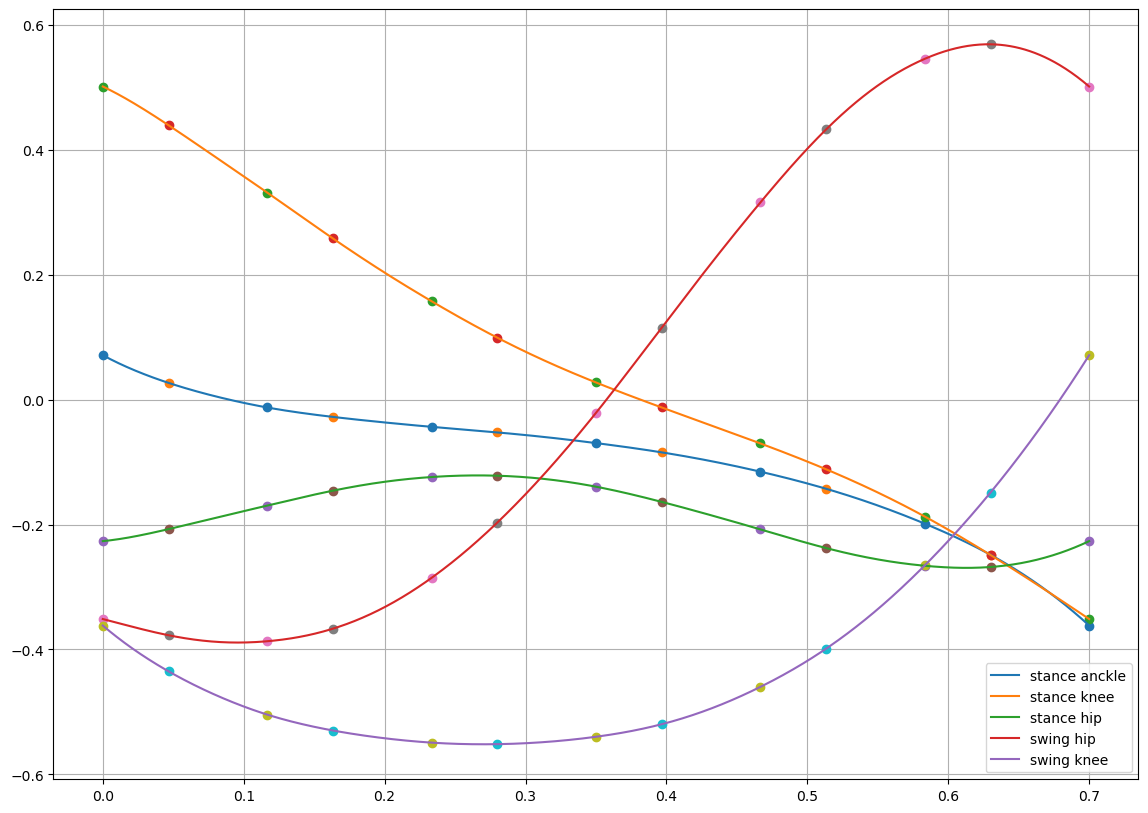

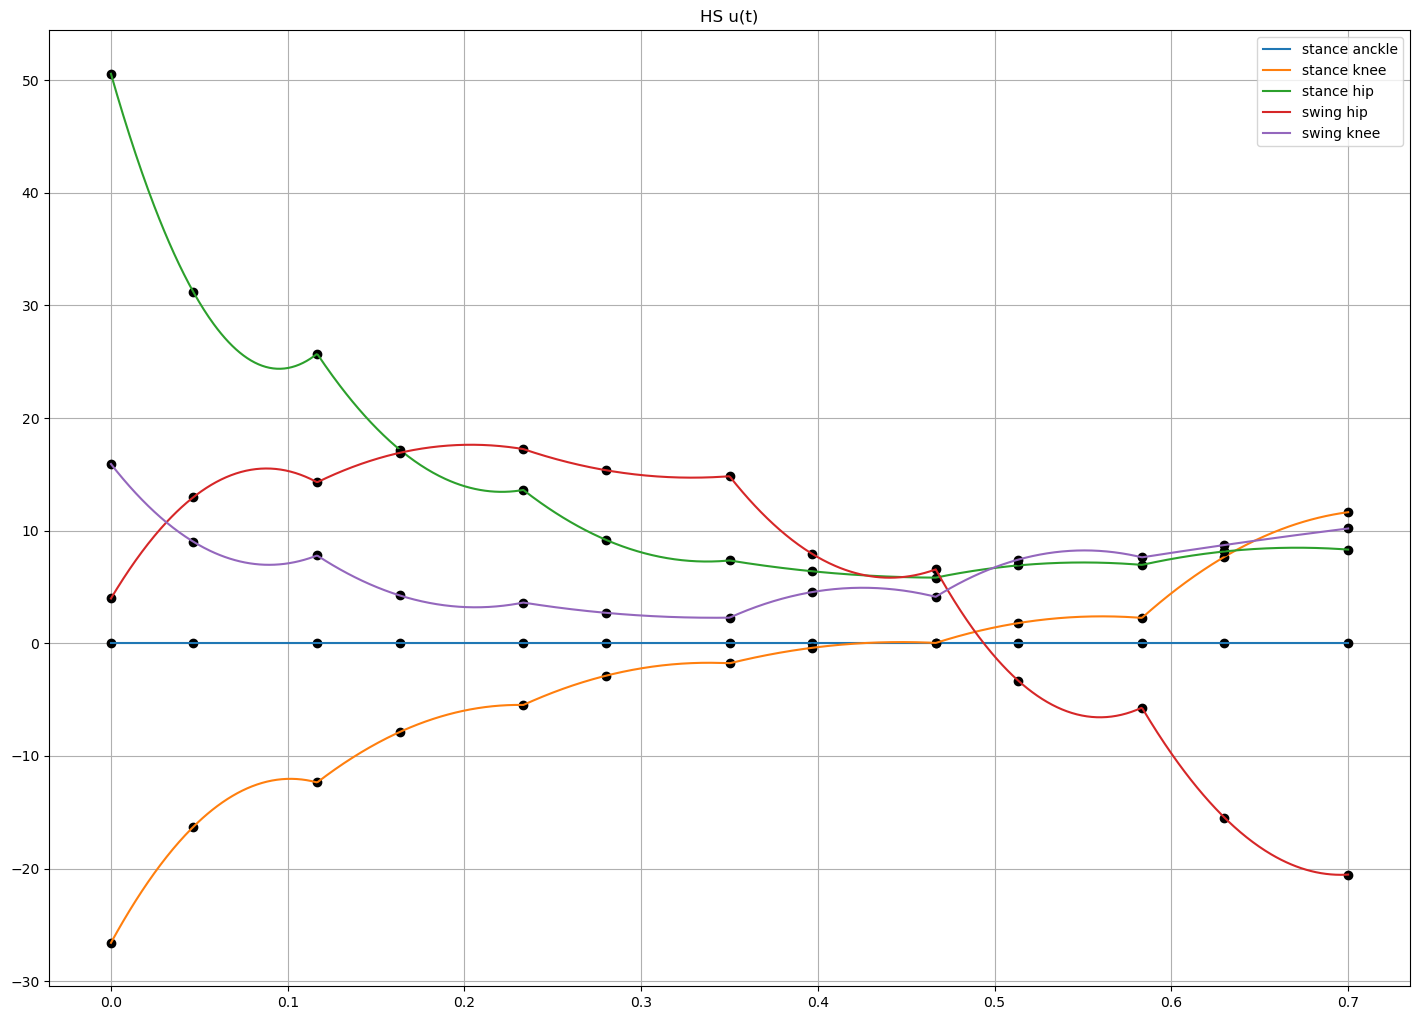

In [45]:
plt.figure(figsize=[14,10])
scheme = scheme
labels= ['stance anckle', 'stance knee', 'stance hip', 'swing hip', 'swing knee']
for ii in range(5):
    plt.plot(_res['t'],_res['q'][:,ii], 'o')#, label = labels[ii]
    plt.plot(_res['t_c'],_res['q_c'][:,ii], 'o')#label = labels[ii] + ' u_c'

n_interp = 1000
t_int_arr = np.linspace(0, _res['t'][-1], n_interp)
u_scheme, scheme_params = config_params_from_scheme(scheme, _res)
int_x, int_u = interpolated_array(
    _res['x'],
    _res['u'],
    _res['t'][-1]/(_res['t'].shape[0]-1),
    t_int_arr,
    params,
    F=None,
    X_dot=_res['x_d'],
    scheme='hsj_parab',
    u_scheme=u_scheme,
    scheme_params=scheme_params,
)
for ii in range(5):
    plt.plot(t_int_arr,int_x[:,ii], label = labels[ii])
plt.grid()
plt.legend()

plt.figure(figsize=[14,10])
for ii in range(5):
    plt.plot(_res['t'],_res['u'][:,ii],'o', c = 'k')#, label = labels[ii]
    plt.plot(_res['t_c'],_res['u_c'][:,ii], 'o', c = 'k')#label = labels[ii] + ' u_c'
    plt.plot(t_int_arr,int_u[:,ii], label = labels[ii])
plt.grid()
plt.legend()
plt.title('HS u(t)')
plt.tight_layout(pad = 0.0)
#plt.savefig('hsj_pics/u_hsj.eps', format='eps')

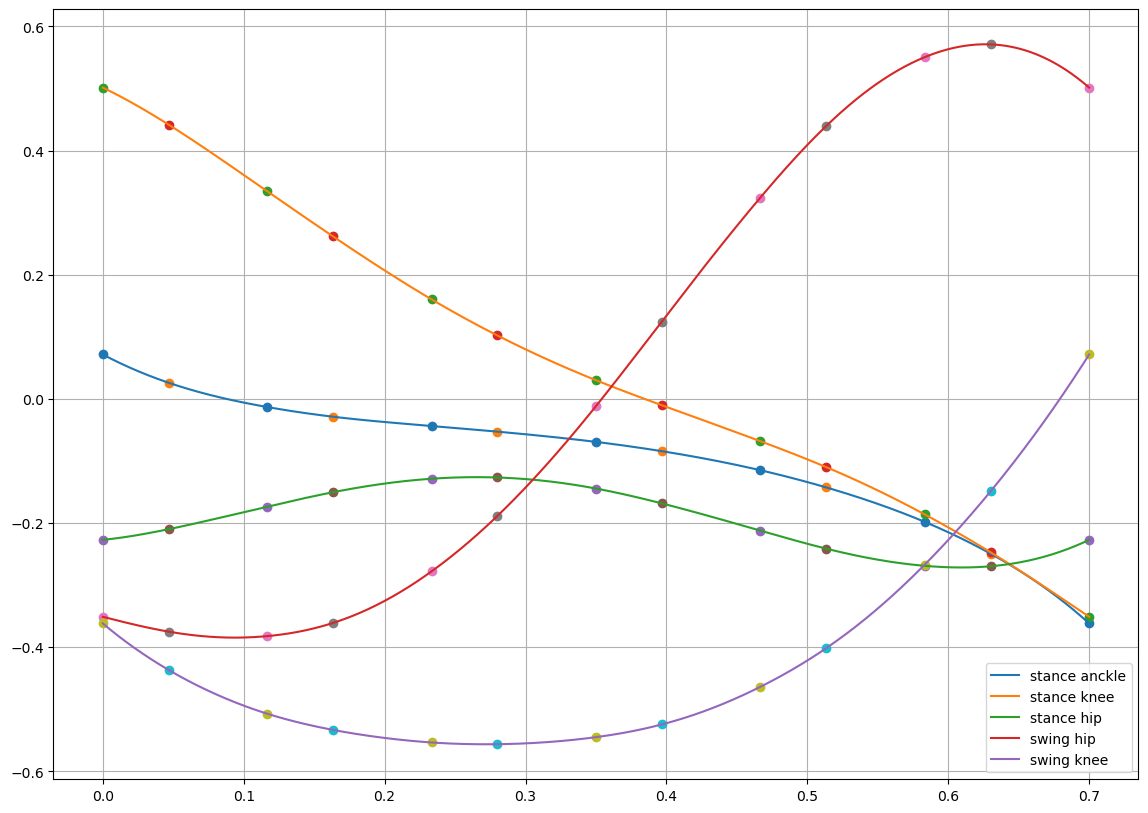

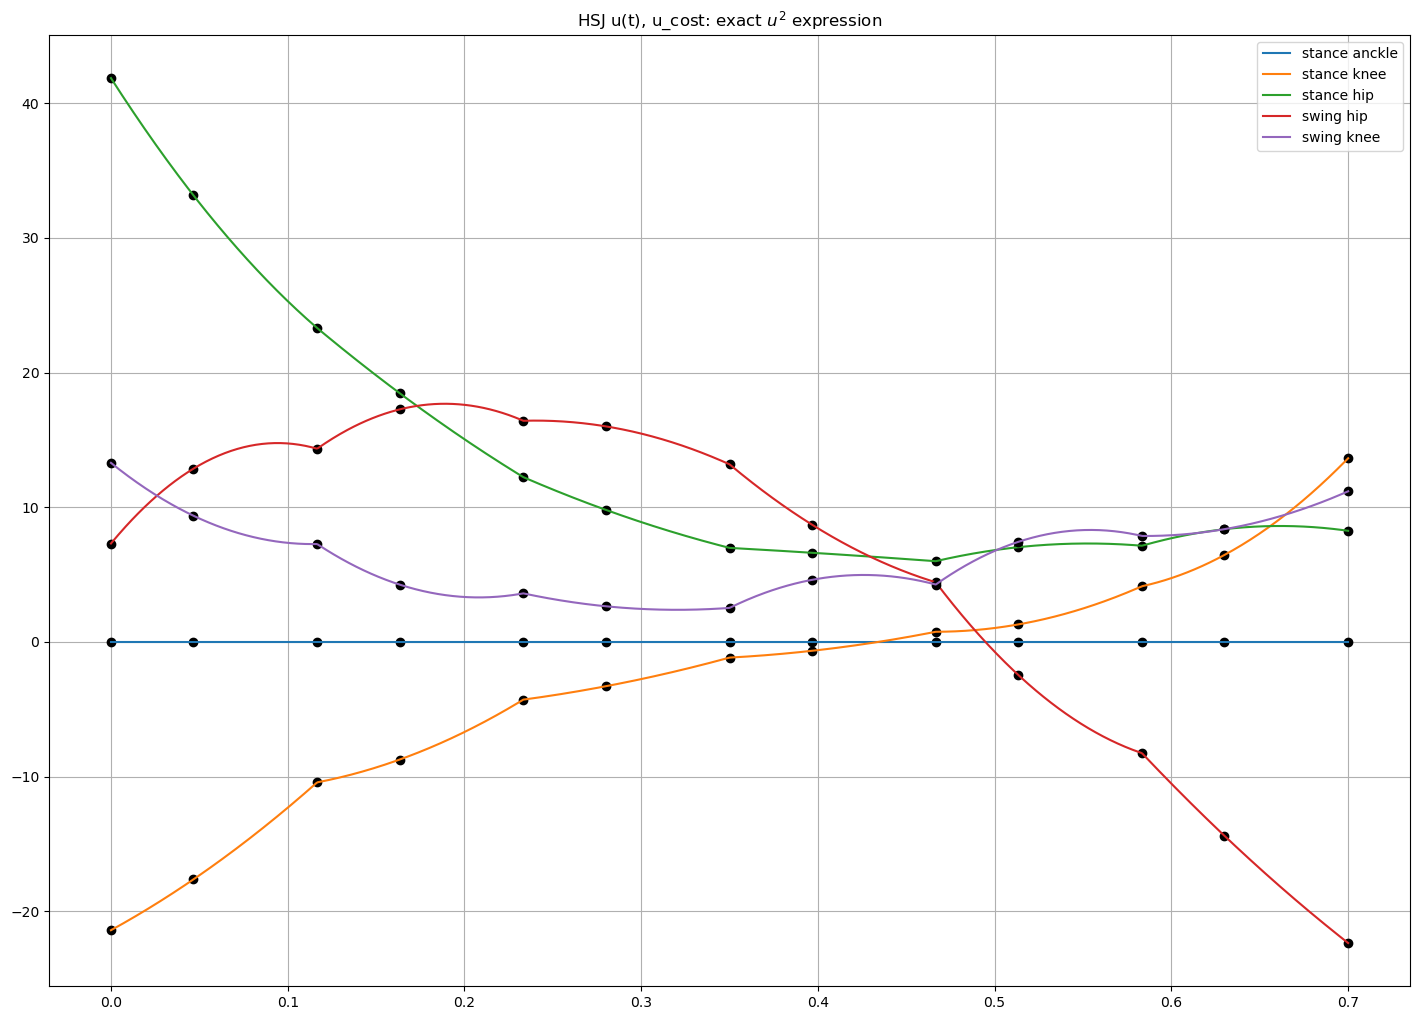

In [46]:
plt.figure(figsize=[14,10])
labels= ['stance anckle', 'stance knee', 'stance hip', 'swing hip', 'swing knee']
for ii in range(5):
    plt.plot(_res_b['t'],_res_b['q'][:,ii], 'o')#, label = labels[ii]
    plt.plot(_res_b['t_c'],_res_b['q_c'][:,ii], 'o')#label = labels[ii] + ' u_c'

n_interp = 1000
t_int_arr = np.linspace(0, _res_b['t'][-1], n_interp)
u_scheme, scheme_params = config_params_from_scheme(scheme_b, _res_b)
int_x, int_u = interpolated_array(
    _res_b['x'],
    _res_b['u'],
    _res_b['t'][-1]/(_res_b['t'].shape[0]-1),
    t_int_arr,
    params,
    F=None,
    X_dot=_res_b['x_d'],
    scheme=scheme_b,
    u_scheme=u_scheme,
    scheme_params=scheme_params,
)
for ii in range(5):
    plt.plot(t_int_arr,int_x[:,ii], label = labels[ii])
plt.grid()
plt.legend()

plt.figure(figsize=[14,10])
for ii in range(5):
    plt.plot(_res_b['t'],_res_b['u'][:,ii], 'o', c = 'k')#, label = labels[ii]
    plt.plot(_res_b['t_c'],_res_b['u_c'][:,ii], 'o', c = 'k')#label = labels[ii] + ' u_c'
    plt.plot(t_int_arr,int_u[:,ii], label = labels[ii])
plt.grid()
plt.legend()
plt.title('HSJ u(t), u_cost: exact $u^2$ expression')
plt.tight_layout(pad = 0.0)
#plt.savefig('hsj_pics/u_hsj_exact.eps', format='eps')

plt.figure(figsize=[14,10])
labels= ['stance tibia', 'stance femur', 'torso', 'swing femur', 'swing tibia']
for ii in range(5):
    plt.plot(T_sol_arr, X_sol[:,ii], marker = 'o', label = labels[ii])
    plt.plot(T_c_arr,X_c_sol[:,ii], 'o', label = labels[ii] + ' x_c')
plt.grid()
plt.legend()

In [47]:
def chain_to_draw(x,params):
    [
    I_0_n, I_1_n, I_2_n, I_3_n, I_4_n,
    d_0_n, d_1_n, d_2_n, d_3_n, d_4_n,
    g_n,
    l_0_n, l_1_n, l_3_n,
    m_0_n, m_1_n, m_2_n, m_3_n, m_4_n
    ] = params
    points_x = [0, ]
    points_y = [0, ]
    points_x.append(points_x[-1] - l_0_n*np.sin(x[0]))
    points_x.append(points_x[-1] - l_1_n*np.sin(x[1]))
    points_x.append(points_x[-1] - l_2_n*np.sin(x[2]))
    points_x.append(points_x[-2])
    points_x.append(points_x[-1] + l_3_n*np.sin(x[3]))
    points_x.append(points_x[-1] + l_4_n*np.sin(x[4]))
    
    
    points_y.append(points_y[-1] + l_0_n*np.cos(x[0]))
    points_y.append(points_y[-1] + l_1_n*np.cos(x[1]))
    points_y.append(points_y[-1] + l_2_n*np.cos(x[2]))
    points_y.append(points_y[-2])
    points_y.append(points_y[-1] - l_3_n*np.cos(x[3]))
    points_y.append(points_y[-1] - l_4_n*np.cos(x[4]))
    
    return points_x, points_y

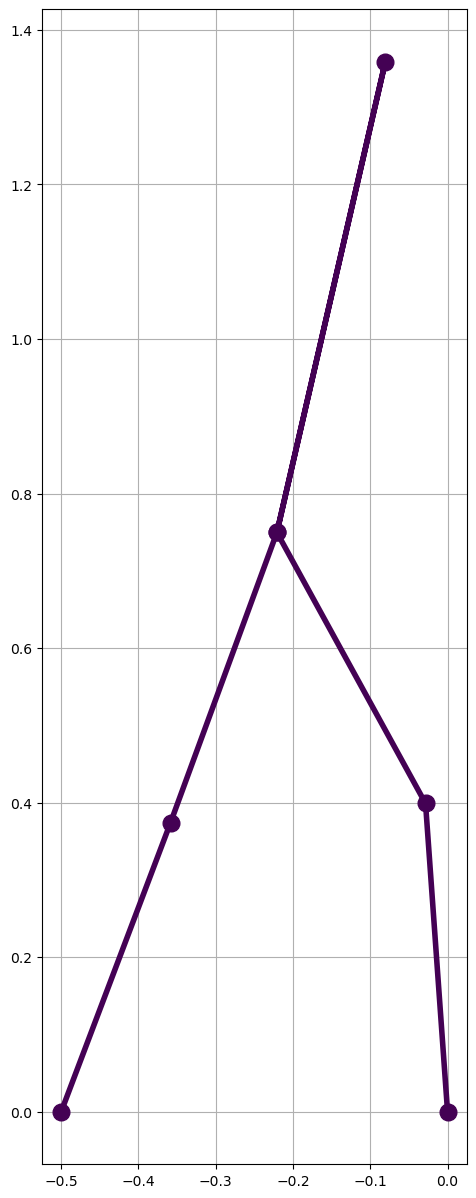

In [48]:
plt.figure(figsize=[15,15])
plt.grid()
for ii in range(0, 1, 1):
    points_x, points_y = chain_to_draw(_res['x'][ii], params)
    plt.plot(points_x, points_y, marker = 'o', lw=4, ms=12, color = plt.cm.viridis(ii/1))
    

plt.gca().set_aspect('equal')

total_mass = m_0_n + m_1_n + m_2_n + m_3_n + m_4_n
ang_mom_arr = [ang_mom_p0_np(X_sol[ii,:],params) for ii in range(N+1)]
ang_mom_swing_foot_arr = [ang_mom_p5_np(X_sol[ii,:],params, additional_params) for ii in range(N+1)]
ang_mom_swing_foot_static_arr = [ang_mom_p5_static_np(X_sol[ii,:],params, additional_params) for ii in range(N+1)]
cm_torque_arr = [total_mass * -g_n * sys_cm_np(X_sol[ii,:], params)[0] for ii in range(N+1)]
ang_mom_arr_deriv = np.gradient(ang_mom_arr, T_sol_arr)

plt.figure(figsize=[15,10])

plt.plot(T_sol_arr, ang_mom_arr, label = 'angular moment around stance foot')
plt.plot(T_sol_arr, ang_mom_swing_foot_arr, label = 'angular moment around swing foot')
plt.plot(T_sol_arr, ang_mom_swing_foot_static_arr, label = 'angular moment around static point at swing foot')
plt.plot(T_sol_arr, cm_torque_arr)
plt.plot(T_sol_arr, ang_mom_arr_deriv)
plt.grid()
plt.legend()

system_energy_arr = [system_energy_np(X_sol[ii,:],params) for ii in range(N+1)]
system_energy_arr_deriv = np.gradient(system_energy_arr, T_sol_arr)
joint_angles = -X_sol[:,:4]+X_sol[:,1:5]
joint_speeds = -X_sol[:,5:9]+X_sol[:,6:10]
external_power = np.sum(joint_speeds*U_sol[:,1:], axis=1)

plt.figure(figsize=[15,10])

plt.plot(T_sol_arr, system_energy_arr)
plt.plot(T_sol_arr, system_energy_arr_deriv)
plt.plot(T_sol_arr, external_power)
plt.grid()

x_guess = X_sol.copy()
x_guess[:,:5] = q_guess
x_guess[:,5:] = q_dot_guess

plt.figure(figsize=[15,15])
plt.grid()
for ii in range(N+1):
    points_x, points_y = chain_to_draw(x_guess[ii], params)
    plt.plot(points_x, points_y, color = plt.cm.viridis(ii/26))
    

plt.gca().set_aspect('equal')

n_graph = 1000
t_arr = np.linspace(0,2,n_graph)
dyn_err_q_hs_lin, dyn_err_v_hs_lin, dyn_err_2_a_hs_lin, dyn_err_2_b_hs_lin = dynamic_error_implicit(
    x_arr=X_sol,
    u_arr=U_sol,
    t_end=T_sol,
    params = params,
    F = F_impl_np,
    M = mass_matrix_np,
    lambda_arr = None,
    scheme = 'hs_parab', 
    u_scheme='parab',
    scheme_params={'u_c':U_c_sol,
                  'x_dot_c': X_dot_c_sol,
                  'x_c': X_c_sol},
    n_interp= n_graph)


for ii in range(5):
    plt.figure(figsize=[14,8])
    plt.plot(t_arr,-dyn_err_q_hs_lin[:,ii], '-', label = f'q {ii}')
    plt.plot(np.linspace(0,2,26), np.zeros(26), 'ok')
    plt.legend()
    plt.grid()


for ii in range(5):
    plt.figure(figsize=[14,8])
    plt.plot(t_arr,dyn_err_v_hs_lin[:,ii], '-', label = f'q {ii}')
    plt.plot(np.linspace(0,2,26), np.zeros(26), 'ok')
    plt.legend()
    plt.grid()
    plt.figure(figsize=[14,8])


for ii in range(5):
    plt.figure(figsize=[14,8])
    plt.plot(t_arr,dyn_err_2_b_hs_lin[:,ii], '-', label = f'q {ii}')
    plt.plot(np.linspace(0,2,26), np.zeros(26), 'ok')
    plt.legend()
    plt.grid()
    plt.figure(figsize=[14,8])


## Sistematic comparative

In [49]:
from functools import lru_cache

In [149]:
def sch_to_lab(sch):
    label_dict = {
        'hs': 'HS-1-Topputo',
        'hs_mod': 'HS-2-Topputo',
        'hs_parab': 'HS-1',
        'hs_mod_parab': 'HS-2',
        'trapz':'TZ-1',
        'trapz_mod':'TZ-2',
        'hsj': 'HSJ-Topputo',
        'hsj_parab': 'HSJ',
        'hsj_parab_mod': 'HSJ (sep $u_c$)',
        'rk4':'rk4',
    }
    return label_dict[sch]

def sch_to_long_label(sch):
    titles = ['Hermite Simpson',
          '2nd order Hermite Simpson',
          'Trapezoidal',
          '2nd order Trapezoidal',
          'Hermite Simpson (Topputo)',
          '2nd order Hermite Simpson (Topputo)',
          'Hermite-Simpson-Jacobi (Topputo)',
          'Hermite-Simpson-Jacobi',
          'Hermite-Simpson-Jacobi (mod_u)',
          'Runge-Kutta 4']
    schemes = ['hs_parab', 'hs_mod_parab','trapz', 'trapz_mod', 'hs', 'hs_mod', 'hsj', 'hsj_parab', 'hsj_parab_mod','rk4']
    lname_dict = {}
    for ii in range(len(titles)):
        lname_dict[schemes[ii]] = titles[ii]
    return lname_dict[sch]
        

def sch_to_color(sch):
    color_dict = {}
    for ii, sc_name in enumerate([
        'hs', 'trapz_mod', 'trapz', 'hs_mod','hs_parab', 'hs_mod_parab',
        'hsj_parab', 'hsj', 'rk4', 'hsj_mod', 'hsj_parab_mod']):
        color_dict[sc_name] = f'C{ii}'
    return color_dict[sch]

def scheme_kwargs(sch, longlabel=False, colors_for_parab = False):
    if colors_for_parab:
        color = sch_to_color(sch)
        ls = '-'
    else:
        color = sch_to_color(sch.replace('_parab', ''))
        if  'hs' in sch and 'parab' not in sch:
            ls = '--'
        else:
            ls = '-'
    kwargs = {'marker' :'o', 'c':color, 'ls':ls}
    if longlabel:
        kwargs['label'] = sch_to_long_label(sch)
    else:
        kwargs['label'] = sch_to_lab(sch)
    return kwargs

In [51]:
plt.rcParams.update({'font.size': 15})
oct_fig_size = [10,6]

In [52]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams.update({'font.size': 15})
oct_fig_size = [10,6]

In [53]:
from chords.analysis import generate_G, dynamic_error_implicit, quad_problem
from chords.piecewise import reduce_F,expand_F, expand_G

In [54]:
G_nump = generate_G(F_impl = F_impl_np,
           M = mass_matrix_np,)

def G_nump_q(q,v,u,params):
    q = np.array(q)
    v = np.array(v)
    x = np.concatenate((q,v), axis = -1)
    return G_nump(x,u,params)

def G_flat(*args, **kwargs):
    x = G_nump(*args, **kwargs)
    return x.flatten()

F_nump = expand_F(G_flat)

In [55]:
def arr_mod(x):
    x_1 = np.sum(x*x, axis=1)
    return np.sqrt(x_1)
def arr_sum(x):
    return np.sum(np.abs(x), axis = 1)
def arr_max(x):
    return np.max(np.abs(x), axis = 1)

In [56]:
def integ_state_error(t_arr, dyn_err):
    int_x = np.zeros_like(dyn_err)
    arr_len = dyn_err.shape[0]
    for ii in range(1,arr_len):
        int_x[ii,:] = np.trapz(dyn_err[:ii+1,:], t_arr[:ii+1], axis=0)
    return int_x

In [57]:
def plot_by_segments(results, schemes, N, thing_to_plot, title, ylabel, component = 'all'):
    plt.figure(figsize=oct_fig_size)
    plot_coll_p = False
    for scheme in schemes:
        t_arr = np.linspace(0,
                        results[scheme][N]['t'][-1],
                        results[scheme][N][thing_to_plot].shape[0])
        interv_n = (N * t_arr)/results[scheme][N]['t'][-1]
        cut_p = 0
        for ll in range(1,N+1):
            jj = np.searchsorted(interv_n, ll)
            y_plot = results[scheme][N][thing_to_plot]
            if component != 'all':
                y_plot = y_plot[:, component]
            plt.plot(
                t_arr[cut_p:jj],
                y_plot[cut_p:jj],
                '-', c = sch_to_color(scheme),
                label = sch_to_lab(scheme) if cut_p == 0 else None)
            cut_p = jj
        if 'hs' in scheme:
            plot_coll_p = True
    plt.plot(results[scheme][N]['t'], np.zeros(N+1), 'ok', ms=5, label = 'knot & collocation points')
    if plot_coll_p:
        plt.plot(results[scheme][N]['t_c'], 
                     np.zeros(N), 'ow', ms=5, markeredgecolor='k',
                     label = 'collocation points')
    plt.legend()
    plt.grid()
    #plt.ylim([-0.01,y_max_list[ii]])
    plt.title(title)
    plt.xlabel('Time(s)')
    plt.ylabel(ylabel)
    plt.tight_layout(pad = 0.0)
    #plt.yscale('log')
    #plt.savefig(f'2d_order/5_link_HS_N{N}_second_order_dynamic_error.pdf', format='pdf')

### Loading a saved run

In [58]:
# If Loading a saved run:
with open('biped_results.pkl', 'rb') as f:
    results = pickle.load(f)
schemes = [ii for ii in results.keys()]

#schemes = ['LG','LG2']#'D2', 'LGL', 
#schemes =['trapz', 'trapz_mod', 'hs', 'hs_mod', 'hsj','hs_parab', 'hs_mod_parab', 'hsj_parab'] 
#
schemes =[ 'hsj_parab_mod'] 

initials = ['lin']#, 'funcs']
solve_repetitions = 10
N_arr = [10, 15, 20, 25, 30, 40, 50, 60, 80, 100, 120, 160, 200]#,50,55]#

#results = {}

for scheme in schemes:
    key = scheme
    print('Problem:', key, f' scheme# {schemes.index(scheme)+1} of total {len(schemes)} schemes')
    results[key] = {'N_arr':N_arr}
    for N in N_arr:
        print(f'\tN = {N} , ', time.strftime('%H:%M:%S ', time.localtime(time.time())))
        results[key][N] = five_link(
            N = N,
            scheme = scheme,
            solve_repetitions = solve_repetitions,
            t_end = 0.7,
            step_length = 0.5)


schemes = ['LGL']#'D2', 'LGL', 
initials = ['lin']#, 'funcs']
solve_repetitions = 1
N_arr = [4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,30]#,35,40,45]#,50,55]#


for scheme in schemes:
    key = scheme
    print('Problem:', key)
    results[key] = {'N_arr':N_arr}
    for N in N_arr:
        print(f'\tN = {N} , ', time.strftime('%H:%M:%S ', time.localtime(time.time())))
        results[key][N] = five_link(
            N = N,
            scheme = scheme,
            solve_repetitions = solve_repetitions,
            t_end = 0.7,
            step_length = 0.5)


schemes = ['LG','LG2', 'LGL']#'D2', 'LGL', 

In [62]:
for scheme in schemes:
    key = scheme
    _c = []
    _cpudt = []
    _iters = []
    for N in results[key]['N_arr']:
        _c.append(results[key][N]['cost'])
        _cpudt.append(results[key][N]['cpudt'])
        _iters.append(results[key][N]['iter_count'])
    results[key]['cost'] = np.array(_c)
    results[key]['cpudt'] = np.array(_cpudt)
    results[key]['iter_count'] = np.array(_iters)

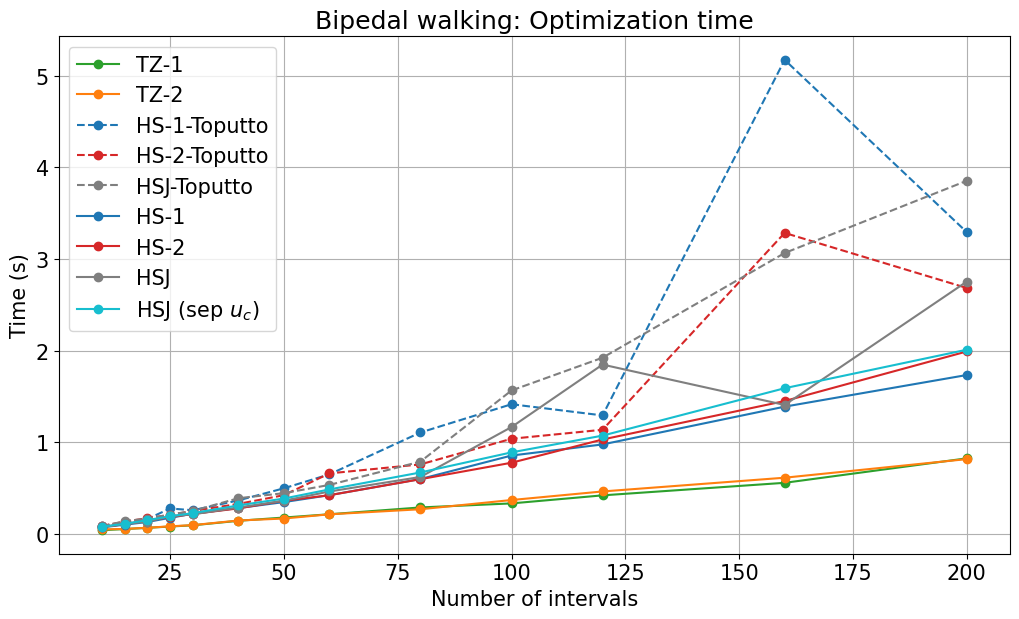

In [60]:
#titles = ['LG','LG2']#'D2', 'LGL', 
schemes_plot =['trapz', 'trapz_mod', 'hs', 'hs_mod', 'hsj','hs_parab', 'hs_mod_parab', 'hsj_parab', 'hsj_parab_mod']
plt.figure(figsize=oct_fig_size)
for ii in range(len(schemes_plot)):
    key = schemes_plot[ii]
    plt.plot(
        results[key]['N_arr'],
        results[key][f'cpudt'],
        **scheme_kwargs(key, longlabel=False)
    )
plt.grid()
plt.legend()
#plt.yscale('log')
plt.title('Bipedal walking: Optimization time')
plt.xlabel('Number of intervals')
plt.ylabel('Time (s)')
plt.tight_layout(pad = 0.0)
#plt.savefig('hsj_pics/5_link_runtime_vs_interval_number.eps', format='eps')

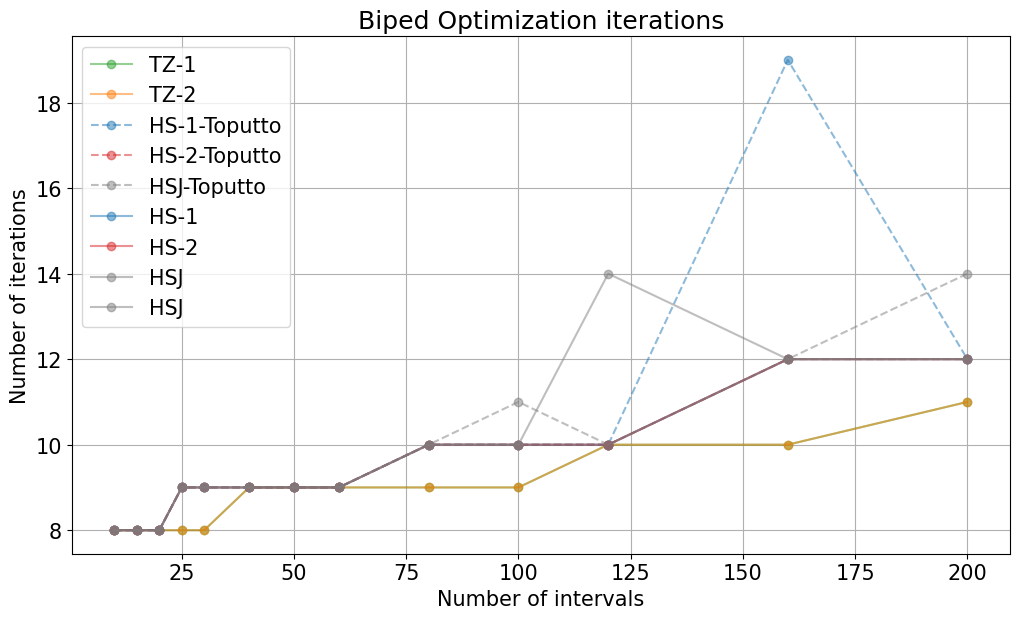

In [72]:
plt.figure(figsize=oct_fig_size)
for ii in range(len(schemes)):
    key = schemes[ii]
    plt.plot(
        results[key]['N_arr'],
        results[key]['iter_count'],
        **scheme_kwargs(key, longlabel=False),
        alpha = 0.5)
plt.grid()
plt.legend()
#plt.yscale('log')
plt.title('Biped Optimization iterations')
plt.ylabel('Number of iterations')
plt.xlabel('Number of intervals')
plt.tight_layout(pad = 0.0)

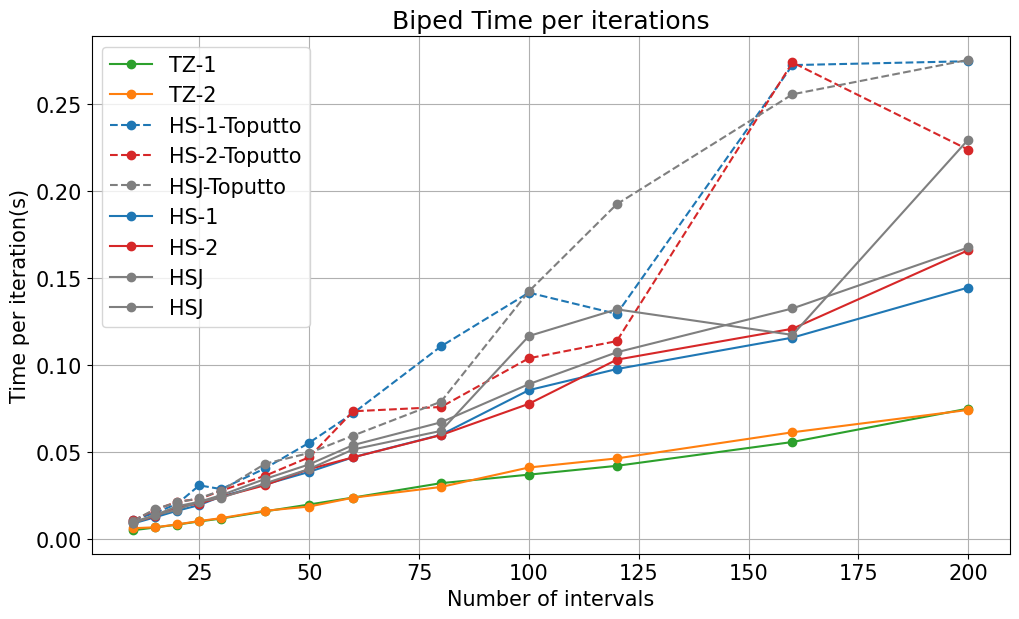

In [73]:
plt.figure(figsize=oct_fig_size)
for ii in range(len(schemes)):
    key = schemes[ii]
    plt.plot(
        results[key]['N_arr'],
        results[key][f'cpudt']/results[key]['iter_count'],
        **scheme_kwargs(key, longlabel=False),
        alpha = 1)
plt.grid()
plt.legend()
#plt.yscale('log')
plt.title('Biped Time per iterations')
plt.ylabel('Time per iteration(s)')
plt.xlabel('Number of intervals')
plt.tight_layout(pad = 0.0)

Text(0.5, 1.0, 'Final traj cost')

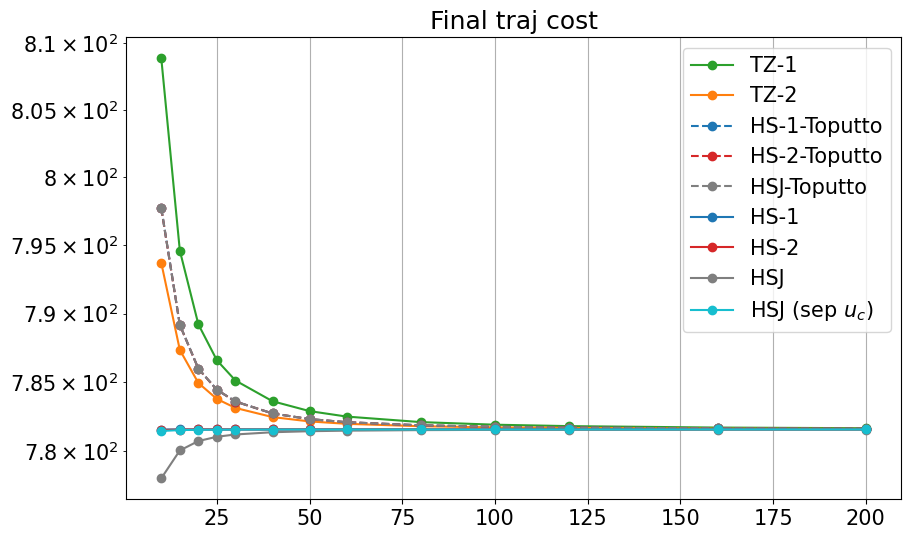

In [61]:
plt.figure(figsize=oct_fig_size)
for scheme in schemes_plot:
    key = scheme
    plt.plot(results[key]['N_arr'],
             results[key]['cost'][:],
             **scheme_kwargs(key, longlabel=False))
plt.yscale('log')
plt.grid()
plt.legend()
plt.title('Final traj cost')

bip_hs = five_link(N = 200,
        scheme = 'hs_parab',
        solve_repetitions = solve_repetitions,
        t_end = 0.7,
        step_length = 0.5)
xx_hs = bip_hs['x']
xx_d_hs = bip_hs['x_d']
xx_c_hs = bip_hs['x_c']
xx_d_c_hs = bip_hs['x_d_c']
uu_hs = bip_hs['u']
uu_c_hs = bip_hs['u_c']
cpudt_hs = bip_hs['cpudt']
sol_cost_hs = bip_hs['cost']

goal = sol_cost_hs

goal

In [76]:
#schemes = ['trapz', 'trapz_mod', 'hs', 'hs_mod', 'hsj']#'hs', 'hs_mod', 


schemes =[ 'hsj_parab_mod']

n_graph = 2000
t_arr = np.linspace(0,0.7,n_graph)
for scheme in schemes:
    key = scheme
    if 'parab' in scheme:
        u_scheme = 'parab'
        if 'j' in scheme:
            u_scheme = 'parab_j'
    else:
        u_scheme = 'lin'
    print('Problem:', key, ', u_scheme:', u_scheme, f' scheme # {schemes.index(scheme)+1} of total {len(schemes)} schemes')
    N_arr = results[key]['N_arr']
    for N in N_arr:
        print(f'\tN = {N}')
        if 'hs' in scheme:
            scheme_params={'u_c':results[key][N]['u_c'],
                          'x_dot_c': results[key][N]['x_d_c'],
                          'x_c': results[key][N]['x_c']}
        else:
            scheme_params={}
        dyn_err_q, dyn_err_v, _, dyn_err_2 = dynamic_error_implicit(
            x_arr=results[key][N]['x'],
            u_arr=results[key][N]['u'],
            t_end=results[key][N]['t'][-1],
            params = params,
            F_impl = F_impl_np,
            M = mass_matrix_np,
            scheme = scheme, 
            u_scheme = u_scheme,
            scheme_params=scheme_params,
            n_interp= n_graph)
        results[key][N]['dyn_err_q'] = dyn_err_q
        results[key][N]['dyn_err_v'] = dyn_err_v
        results[key][N]['dyn_err_2'] = dyn_err_2
        results[key][N][f'sum_dyn_err_2_arr'] = arr_sum(results[key][N]['dyn_err_2'])

Problem: hsj_parab_mod , u_scheme: parab_j  scheme # 1 of total 1 schemes
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 60
	N = 80
	N = 100
	N = 120
	N = 160
	N = 200


schemes = ['hs_parab','hs_mod_parab', 'trapz', 'trapz_mod']
titles = ['Hermite Simpson','2nd order Hermite Simpson', 'Trapezoidal', '2nd order Trapezoidal']
colors = ['b', 'orange', 'g', 'r', 'purple']
n_int = len(t_arr)
N = 25
interv_n = (N * t_arr)/results[scheme][N]['t']
for kk in range(len(schemes)):
    scheme = schemes[kk]
    plt.figure(figsize=[14,8])
    for ii in range(5):
        cut_p = 0
        for ll in range(1,N+1):
            jj = np.searchsorted(interv_n, ll)
            plt.plot(t_arr[cut_p:jj],results[scheme][N]['dyn_err_q'][cut_p:jj,ii], '-', c = colors[ii], label = f'$q_{ii+1}$' if cut_p == 0 else None)
            cut_p = jj
    plt.plot(np.linspace(0,results[scheme][N]['t'],N+1), np.zeros(N+1), 'ok')
    plt.legend()
    plt.grid()
    if kk == 1:
        plt.ylim([-0.00001, 0.00001])
    elif kk == 3:
        plt.ylim([-0.001, 0.001])
    plt.title(r'First order dynamic error $\varepsilon^{[1]}_{q_i}$,'+f' {titles[kk]} scheme')
    plt.xlabel('Time(s)')
    plt.ylabel('Dynamic error $(rad/s)$')
    plt.tight_layout(pad = 0.0)
    sch_type = titles[kk].replace(' ','_')
    plt.savefig(f'5_link_First_Order_Dynamic_Error_{sch_type}_scheme.eps', format='eps')


schemes = ['hs_parab','hs_mod_parab', 'trapz', 'trapz_mod']
titles = ['Hermite Simpson','2nd order Hermite Simpson', 'Trapezoidal', '2nd order Trapezoidal']
colors = ['b', 'orange', 'g', 'r', 'purple']
n_int = len(t_arr)
N = 25
interv_n = (N * t_arr)/results[scheme][N]['t']
for kk in range(len(schemes)):
    scheme = schemes[kk]
    plt.figure(figsize=[14,8])
    for ii in range(5):
        cut_p = 0
        for ll in range(1,N+1):
            jj = np.searchsorted(interv_n, ll)
            plt.plot(t_arr[cut_p:jj],results[scheme][N]['dyn_err_2'][cut_p:jj,ii], '-', c = colors[ii], label = f'$q_{ii+1}$' if cut_p == 0 else None)
            cut_p = jj
    plt.plot(results[scheme][N]['t_array'], np.zeros(N+1), 'ok', label = 'knot & collocation points')
    if 'hs' in scheme:
        plt.plot(results[scheme][N]['t_c_array'], np.zeros(N), 'ow', markeredgecolor='b', label = 'collocation points')
        plt.ylim([-0.08, 0.08])
    else:
        plt.ylim([-1.75, 1.75])
    plt.legend()
    plt.grid()
    plt.title(r'Second order dynamic error $\varepsilon^{{[2]}}_{{q_i}}$,'+f' {titles[kk]} scheme')
    plt.xlabel('Time(s)')
    plt.ylabel('Dynamic error $(rad/s^2)$')
    plt.tight_layout(pad = 0.0)
    sch_type = titles[kk].replace(' ','_')
    plt.savefig(f'5_link_Second_Order_Dynamic_Error_{sch_type}_scheme.eps', format='eps')


for key in results.keys():
    print('Problem:', key)
    N_arr = results[key]['N_arr']
    for N in N_arr:
        #print(f'\tN = {N}')
        _case = results[key][N]
        t_arr = np.linspace(0,
                        _case['t'][-1],
                        _case['dyn_err_2'].shape[0])
       if 'hs' in key:
            scheme_params={'u_c':_case['u_c'],
                          'x_dot_c': _case['x_d_c'],
                          'x_c': _case['x_c']}
        else:
            scheme_params={}
            
        _derivs = interpolated_array_derivative(
            _case['x'],
            _case['u'],
            _case['t'][-1]/(_case['t'].shape[0]-1),
            t_array = t_arr,
            params=params,
            F=None,
            X_dot=_case['x_d'],
            scheme=key,
            order=1,
            scheme_params=scheme_params,)
_accels = _derivs[:, 5:]
        
        _case[f'sum_dyn_err_2_arr'] = arr_sum(_case['dyn_err_2'])
        _case['a_arr'] = _accels
        _case['a_abs_mean_by_component'] = np.mean(np.abs(_accels), axis = 0)
        _case['a_abs_mean'] = np.mean(np.abs(_accels))
        _case['a_abs_sum_arr'] = arr_sum(_accels)
        
        _case['rel_dyn_err_2_arr_by_instant_a_sum'] = arr_sum(_case['dyn_err_2']/_case['a_arr'])
        _case['rel_dyn_err_2_arr_by_total_mean_sum'] = _case[f'sum_dyn_err_2_arr']/_case['a_abs_mean']
        _case['rel_dyn_err_2_arr_by_mean_by_component_sum'] = arr_sum(_case['dyn_err_2']/_case['a_abs_mean_by_component'])
        _case['rel_dyn_err_2_arr_by_a_sum_arr_sum'] = _case[f'sum_dyn_err_2_arr']/_case['a_abs_sum_arr']

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


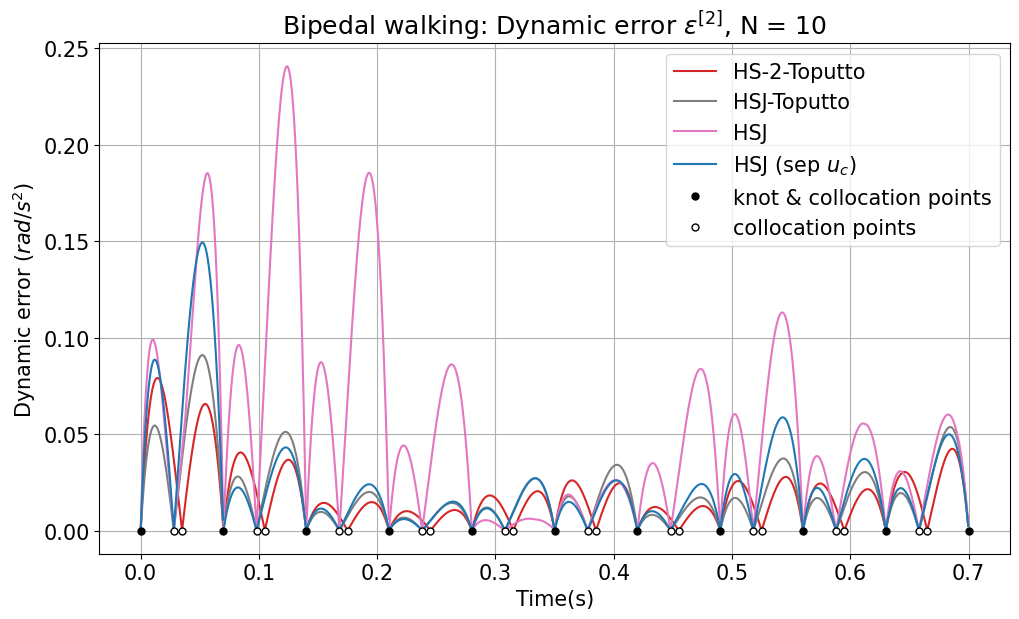

In [161]:
schemes_plot = ['hs_mod', 'hsj', 'hsj_parab', 'hsj_parab_mod']
N = 10
plot_by_segments(results, schemes_plot, N,
                 thing_to_plot = 'sum_dyn_err_2_arr',
                 title = r'Bipedal walking: Dynamic error $\varepsilon^{[2]}$,'+f' N = {N}',
                 ylabel = 'Dynamic error $(rad/s^2)$')
plt.plot(np.linspace(0,0.7, 2*N+1)[1::2], np.zeros(N), 'ow', ms=5, markeredgecolor='k')
#plt.savefig('hsj_pics/5_link_HSJ_N{N}_second_order_dynamic_error.eps', format='eps')

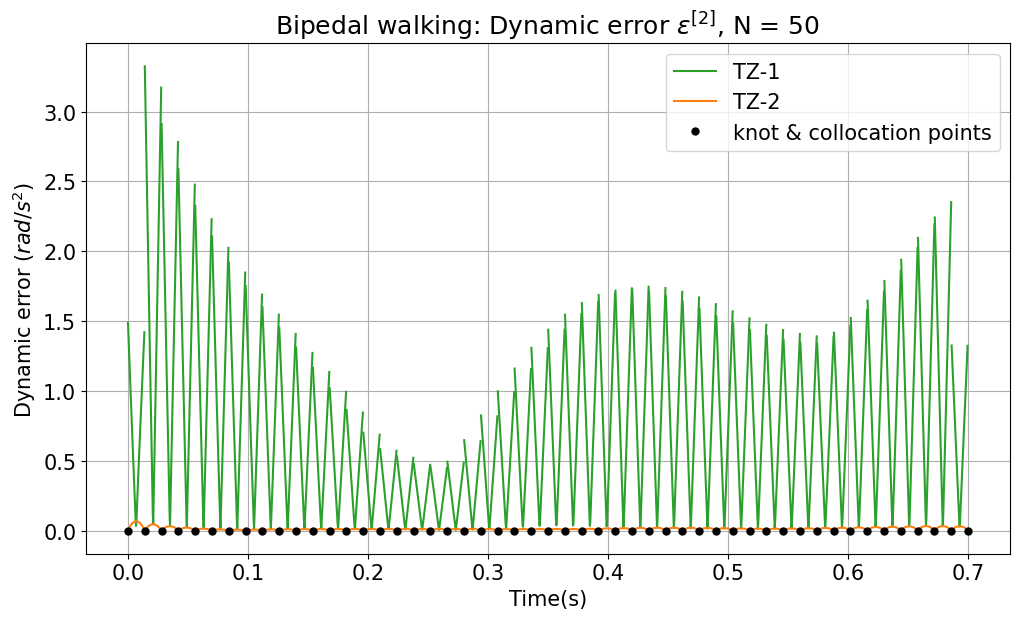

In [71]:
schemes_plot = ['trapz', 'trapz_mod']#, 'trapz', 'trapz_mod']
N = 50
plot_by_segments(results, schemes_plot, N,
                 thing_to_plot = 'sum_dyn_err_2_arr',
                 title = r'Bipedal walking: Dynamic error $\varepsilon^{[2]}$,'+f' N = {N}',
                 ylabel = 'Dynamic error $(rad/s^2)$')

#plt.savefig(f'2d_order/5_link_Trapezoidal_N{N}_second_order_dynamic_error.eps', format='eps')

def state_error(t_arr, dyn_err, N,):
    n_int = len(t_arr)
    interv_n = (N * t_arr)//2
    err = []
    cut_p = 0
    for ii in range(1,N+1):
        jj = np.searchsorted(interv_n, ii)
        err_point = np.trapz(np.abs(dyn_err[cut_p:jj+1]), t_arr[cut_p:jj+1], axis=0)
        err.append(err_point)
        cut_p = jj
    err = np.array(err, dtype = float)
    return err

def total_state_error(t_arr, dyn_err):
    errors = np.trapz(dyn_err, t_arr, axis=0)
    return errors


def total_state_error_abs(t_arr, dyn_err):
    errors = np.trapz(np.abs(dyn_err), t_arr, axis=0)
    return errors

In [90]:
def total_state_error(t_arr, dyn_err):
    errors = np.trapz(np.abs(dyn_err), t_arr, axis=0)
    return errors

In [91]:


#schemes = ['trapz', 'trapz_mod', 'hs', 'hs_mod', 'hsj']

t_arr = np.linspace(0,0.7,n_graph)
for scheme in schemes:
    key = scheme
    print('Problem:', key)
    N_arr = results[key]['N_arr']
    for N in N_arr:
        #print(f'\tN = {N}')
        for letter in 'qv2':
            results[key][N][f'integ_dyn_err_{letter}']= total_state_error(t_arr, results[scheme][N][f'dyn_err_{letter}'])
            results[key][N][f'module_dyn_err_{letter}']= np.sqrt(np.dot(results[key][N][f'integ_dyn_err_{letter}'], results[key][N][f'integ_dyn_err_{letter}']))
            results[key][N][f'sum_dyn_err_{letter}'] = np.sum(results[key][N][f'integ_dyn_err_{letter}'])

Problem: hsj_parab_mod


In [92]:
#schemes = ['trapz', 'trapz_mod', 'hs', 'hs_mod', 'hsj']#'hs', 'hs_mod', 

t_arr = np.linspace(0,0.7,n_graph)
for scheme in schemes:
    key = scheme
    print('Problem:', key)
    N_arr = results[key]['N_arr']
    for N in N_arr:
        #print(f'\tN = {N}')
        for letter in 'qv2':
            results[key][N][f'integ_dyn_err_{letter}']= total_state_error(t_arr, results[scheme][N][f'dyn_err_{letter}'])
            results[key][N][f'module_dyn_err_{letter}']= np.sqrt(np.dot(results[key][N][f'integ_dyn_err_{letter}'], results[key][N][f'integ_dyn_err_{letter}']))
            results[key][N][f'sum_dyn_err_{letter}'] = np.sum(np.abs(results[key][N][f'integ_dyn_err_{letter}']))
        

Problem: hsj_parab_mod


schemes = ['trapz', 'trapz_mod']#['hs_parab', 'hs_mod_parab',]##'hs', 'hs_mod', 


for scheme in schemes:
    key = scheme
    print('Problem:', key)
    N_arr = results[key]['N_arr']
    if 'parab' in scheme:
        u_scheme = 'parab'
    else:
        u_scheme = 'lin'
    
    for N in N_arr:
        print(f'\tN = {N}')
        
        if 'hs' in scheme:
            scheme_params={'u_c':results[key][N]['u_c'],
                          'x_dot_c': results[key][N]['x_d_c'],
                          'x_c': results[key][N]['x_c']}
        else:
            scheme_params={}
            
        results[key][N]['sum_dyn_err_2'] = np.sum(quad_problem(
            x_arr = results[key][N]['x'],
            u_arr = results[key][N]['u'],
            t_arr = results[key][N]['t'],
            params = params,
            F = F_nump,
            scheme = scheme,
            u_scheme = u_scheme,
            scheme_params = scheme_params))

schemes = ['hs_parab', 'hs_mod_parab','trapz', 'trapz_mod']#'hs', 'hs_mod', 

t_arr = np.linspace(0,0.7,n_graph)
for scheme in schemes:
    key = scheme
    print('Problem:', key)
    N_arr = results[key]['N_arr']
    for N in N_arr:
        print(f'\tN = {N}')
        results[key][N]['integ_err_2'] = integ_state_error(t_arr, results[key][N]['dyn_err_2'])
        results[key][N]['twice_integ_err_2'] = integ_state_error(t_arr, results[key][N]['integ_err_2'])
        

sch = [['hs_parab','hs_mod_parab'],['trapz', 'trapz_mod']]
tit = [['Hermite Simpson','2nd order Hermite Simpson'],['Trapezoidal', '2nd order Trapezoidal']]
colors = [f'C{ii}' for ii in [1,0,2,3]]
n_int = len(t_arr)
N_hh = [25,50]
t_end = 0.7
for hh in range(2):
    schemes = sch[hh]
    titles = tit[hh]
    N = N_hh[hh]
    interv_n = (N * t_arr)/2
    for ii in range(5):
        plt.figure(figsize=oct_fig_size)
        for kk in range(len(schemes)):
            scheme = schemes[kk]
            key = scheme
            cut_p = 0
            for ll in range(1,N+1):
                jj = np.searchsorted(interv_n, ll)
                plt.plot(t_arr[cut_p:jj],results[key][N]['integ_err_2'][cut_p:jj,ii], '-', c = colors[2*hh+kk], label = titles[kk] if cut_p == 0 else None)
                cut_p = jj
        plt.plot(np.linspace(0,t_end,N+1), np.zeros(N+1), 'ok', label = 'knot & collocation points')
        if hh == 0:
            plt.plot(np.linspace(0,t_end,2*N+1)[1::2], np.zeros(N), 'ow', markeredgecolor='k', label = 'collocation points')
        plt.legend()
        plt.grid()
        #plt.ylim([-0.00022, 0.00022])
        plt.title(r'Integrated Second order dynamic error $\int_{0}^{t}\varepsilon^{[2]}_{q_'+f'{ii+1}}}'+r'(\tau) d\tau$,'+f'\n{titles[0]} schemes, N = {N}')
        plt.xlabel('Time(s)')
        units = 'm/s' if ii == 0 else'rad/s'
        plt.ylabel(f'Dynamic error $({units})$')
        plt.tight_layout(pad = 0.0)
        sch_type = titles[0].replace(' ','_')
        #plt.savefig(f'Biped_Integrated_Second_Order_Dynamic_Error_q_{ii+1}_{sch_type}_schemes_N_{N}.png', format='png')

sch = [['hs_parab','hs_mod_parab'],['trapz', 'trapz_mod']]
tit = [['Hermite Simpson','2nd order Hermite Simpson'],['Trapezoidal', '2nd order Trapezoidal']]
colors = [f'C{ii}' for ii in [1,0,2,3]]
n_int = len(t_arr)
N_hh = [25,50]
t_end = 0.7
for hh in range(2):
    schemes = sch[hh]
    titles = tit[hh]
    N = N_hh[hh]
    interv_n = (N * t_arr)/2
    for ii in range(5):
        plt.figure(figsize=oct_fig_size)
        for kk in range(len(schemes)):
            scheme = schemes[kk]
            key = scheme
            cut_p = 0
            for ll in range(1,N+1):
                jj = np.searchsorted(interv_n, ll)
                plt.plot(t_arr[cut_p:jj],results[key][N]['twice_integ_err_2'][cut_p:jj,ii], '-', c = colors[2*hh+kk], label = titles[kk] if cut_p == 0 else None)
                cut_p = jj
        plt.plot(np.linspace(0,t_end,N+1), np.zeros(N+1), 'ok', label = 'knot & collocation points')
        if hh == 0:
            plt.plot(np.linspace(0,t_end,2*N+1)[1::2], np.zeros(N), 'ow', markeredgecolor='k', label = 'collocation points')
        plt.legend()
        plt.grid()
        #plt.ylim([-0.00022, 0.00022])
        plt.title(r'Twice integrated second order dynamic error $\int_{0}^{t}\int_{0}^{\xi}\varepsilon^{[2]}_{q_'+f'{ii+1}}}'+r'(\tau) d\tau d\xi$,'+f'\n{titles[0]} schemes, N = {N}')
        plt.xlabel('Time(s)')
        units = 'm' if ii == 0 else'rad'
        plt.ylabel(f'Dynamic error $({units})$')
        plt.tight_layout(pad = 0.0)
        sch_type = titles[0].replace(' ','_')
       # plt.savefig(f'Biped_Twice_Integrated_Second_Order_Dynamic_Error_q_{ii+1}_{sch_type}_schemes_N_{N}.png', format='png')

schemes = ['hs_mod_parab','hs_parab']#, 'trapz', 'trapz_mod']
titles = ['2nd order Hermite Simpson','Hermite Simpson']#, 'Trapezoidal', 'Modified Trapezoidal']
colors = ['b', 'orange', 'g', 'r', 'purple']
funcs = [arr_sum,]#arr_mod,  arr_max
func_tittles = ['Module of', 'Sum of absolute', 'Maximum of absolute']
y_max_list = [0.12, 0.2, 0.09]
n_int = len(t_arr)
N = 25
interv_n = (N * t_arr)/results[scheme][N]['t'][-1]
for ii in range(1):
    plt.figure(figsize=oct_fig_size)
    for kk in [1,0]:
        scheme = schemes[kk]
        cut_p = 0
        for ll in range(1,N+1):
            jj = np.searchsorted(interv_n, ll)
            y_plot = funcs[ii](results[scheme][N]['integ_err_2'])
            plt.plot(t_arr[cut_p:jj],y_plot[cut_p:jj], '-', c = f'C{kk}', label = titles[kk] if cut_p == 0 else None)
            cut_p = jj
    plt.plot(results[scheme][N]['t'], np.zeros(N+1), 'ok', label = 'knot & collocation points')
    plt.plot(results[scheme][N]['t_c'], np.zeros(N), 'ow', markeredgecolor='k', label = 'collocation points')
    plt.legend()
    plt.grid()
    #plt.ylim([-0.01,y_max_list[ii]])
    plt.title(r'Sum of absolute Integrated Second order dynamic error $\Sigma |\int_{0}^{t}\varepsilon^{[2]}_{q_'+f'{ii+1}}}'+r'(\tau) d\tau|$,'+f' HS schemes, N = {N}')
    plt.xlabel('Time(s)')
    plt.ylabel('Dynamic error $(rad/s)$')
    plt.tight_layout(pad = 0.0)
    sch_type = func_tittles[ii].replace(' ','_')
    #plt.savefig(f'5_link_HS_N{N}_integrated_second_order_dynamic_error.png', format='png')
    


schemes = ['trapz', 'trapz_mod']#
titles = ['Trapezoidal', 'Modified Trapezoidal']#
colors = ['b', 'orange', 'g', 'r', 'purple']
funcs = [arr_sum,]#arr_mod,  arr_max
func_tittles = ['Module of', 'Sum of absolute', 'Maximum of absolute']
y_max_list = [0.12, 0.2, 0.09]
n_int = len(t_arr)
N = 25
interv_n = (N * t_arr)/results[scheme][N]['t'][-1]
for ii in range(1):
    plt.figure(figsize=oct_fig_size)
    for kk in [1,0]:
        scheme = schemes[kk]
        cut_p = 0
        for ll in range(1,N+1):
            jj = np.searchsorted(interv_n, ll)
            y_plot = funcs[ii](results[scheme][N]['integ_err_2'])
            plt.plot(t_arr[cut_p:jj],y_plot[cut_p:jj], '-', c = f'C{kk+2}', label = titles[kk] if cut_p == 0 else None)
            cut_p = jj
    plt.plot(results[scheme][N]['t'], np.zeros(N+1), 'ok', label = 'knot & collocation points')
    #plt.plot(results[scheme][N]['t_c'], np.zeros(N), 'ow', markeredgecolor='k', label = 'collocation points')
    plt.legend()
    plt.grid()
    #plt.ylim([-0.01,y_max_list[ii]])
    plt.title(r'Sum of absolute Integrated Second order dynamic error $\Sigma |\int_{0}^{t}\varepsilon^{[2]}_{q_'+f'{ii+1}}}'+r'(\tau) d\tau|$,'+f' Trapz schemes, N = {N}')
    plt.xlabel('Time(s)')
    plt.ylabel('Dynamic error $(rad/s)$')
    plt.tight_layout(pad = 0.0)
    sch_type = func_tittles[ii].replace(' ','_')
   #plt.savefig(f'5_link_Trapz_N{N}_integrated_second_order_dynamic_error.png', format='png')
    


schemes = ['hs_mod_parab','hs_parab']#, 'trapz', 'trapz_mod']
titles = ['2nd order Hermite Simpson','Hermite Simpson']#, 'Trapezoidal', 'Modified Trapezoidal']
colors = ['b', 'orange', 'g', 'r', 'purple']
funcs = [arr_sum,]#arr_mod,  arr_max
func_tittles = ['Module of', 'Sum of absolute', 'Maximum of absolute']
y_max_list = [0.12, 0.2, 0.09]
n_int = len(t_arr)
N = 25
interv_n = (N * t_arr)/results[scheme][N]['t'][-1]
for ii in range(1):
    plt.figure(figsize=oct_fig_size)
    for kk in [1,0]:
        scheme = schemes[kk]
        cut_p = 0
        for ll in range(1,N+1):
            jj = np.searchsorted(interv_n, ll)
            y_plot = funcs[ii](results[scheme][N]['twice_integ_err_2'])
            plt.plot(t_arr[cut_p:jj],y_plot[cut_p:jj], '-', c = f'C{kk}', label = titles[kk] if cut_p == 0 else None)
            cut_p = jj
    plt.plot(results[scheme][N]['t'], np.zeros(N+1), 'ok', label = 'knot & collocation points')
    plt.plot(results[scheme][N]['t_c'], np.zeros(N), 'ow', markeredgecolor='k', label = 'collocation points')
    plt.legend()
    plt.grid()
    #plt.ylim([-0.01,y_max_list[ii]])
    plt.title(r'Sum of absolute twice integrated second order dynamic error $\Sigma |\int_{0}^{t}\int_{0}^{\xi}\varepsilon^{[2]}_{q_'+f'{ii+1}}}'+r'(\tau) d\tau d\xi|$,'+f' HS schemes, N = {N}')
    plt.xlabel('Time(s)')
    plt.ylabel('Dynamic error $(rad)$')
    plt.tight_layout(pad = 0.0)
    sch_type = func_tittles[ii].replace(' ','_')
 #plt.savefig(f'5_link_HS_N{N}_twice_integrated_second_order_dynamic_error.png', format='png')
    


schemes = ['trapz', 'trapz_mod']#
titles = ['Trapezoidal', 'Modified Trapezoidal']#
colors = ['b', 'orange', 'g', 'r', 'purple']
funcs = [arr_sum,]#arr_mod,  arr_max
func_tittles = ['Module of', 'Sum of absolute', 'Maximum of absolute']
y_max_list = [0.12, 0.2, 0.09]
n_int = len(t_arr)
N = 25
interv_n = (N * t_arr)/results[scheme][N]['t'][-1]
for ii in range(1):
    plt.figure(figsize=oct_fig_size)
    for kk in [1,0]:
        scheme = schemes[kk]
        cut_p = 0
        for ll in range(1,N+1):
            jj = np.searchsorted(interv_n, ll)
            y_plot = funcs[ii](results[scheme][N]['twice_integ_err_2'])
            plt.plot(t_arr[cut_p:jj],y_plot[cut_p:jj], '-', c = f'C{kk+2}', label = titles[kk] if cut_p == 0 else None)
            cut_p = jj
    plt.plot(results[scheme][N]['t'], np.zeros(N+1), 'ok', label = 'knot & collocation points')
    #plt.plot(results[scheme][N]['t_c'], np.zeros(N), 'ow', markeredgecolor='k', label = 'collocation points')
    plt.legend()
    plt.grid()
    #plt.ylim([-0.01,y_max_list[ii]])
    plt.title(r'Sum of absolute twice integrated second order dynamic error $\Sigma |\int_{0}^{t}\int_{0}^{\xi}\varepsilon^{[2]}_{q_'+f'{ii+1}}}'+r'(\tau) d\tau d\xi|$,'+f' Trapz schemes, N = {N}')
    plt.xlabel('Time(s)')
    plt.ylabel('Dynamic error $(rad)$')
    plt.tight_layout(pad = 0.0)
    sch_type = func_tittles[ii].replace(' ','_')
   #plt.savefig(f'5_link_Trapz_N{N}_twice_integrated_second_order_dynamic_error.png', format='png')
    


schemes = ['hs_parab', 'hs_mod_parab','trapz', 'trapz_mod']#'hs', 'hs_mod', 

t_arr = np.linspace(0,0.7,n_graph)
for scheme in schemes:
    key = scheme
    print('Problem:', key)
    N_arr = results[key]['N_arr']
    _sum = []
    for N in N_arr:
        results[key][N]['twice_integ_dyn_err_2'] = results[key][N]['twice_integ_err_2'][-1,:]
        results[key][N][f'sum_twice_dyn_err_2'] = np.sum(np.abs(results[key][N]['twice_integ_dyn_err_2']))
        _sum.append(results[key][N][f'sum_twice_dyn_err_2'])
    results[key][f'sum_twice_dyn_err_2_array'] = np.array(_sum)

In [93]:
for scheme in schemes:
    key = scheme
    print('Problem:', key)
    N_arr = results[key]['N_arr']
    
    for letter in 'qv2':
        list_mod = []
        list_sum = []
        for N in N_arr:
            #print(f'\tN = {N}')
            list_mod.append(results[key][N][f'module_dyn_err_{letter}'])
            list_sum.append(np.sum(results[key][N][f'sum_dyn_err_{letter}']))
        results[key][f'module_dyn_err_{letter}_array'] = np.array(list_mod)
        results[key][f'sum_dyn_err_{letter}_array'] = np.array(list_sum)

Problem: hsj_parab_mod


In [94]:
for scheme in results.keys():
    if 'hs' in scheme:
        n_coll = np.array(results[scheme]['N_arr'])*2-1
        results[scheme]['N_coll_arr'] = n_coll
    else:
        results[scheme]['N_coll_arr'] = results[scheme]['N_arr']
    print(scheme, results[scheme]['N_arr'],results[scheme]['N_coll_arr'])

trapz [10, 15, 20, 25, 30, 40, 50, 60, 80, 100, 120, 160, 200] [10, 15, 20, 25, 30, 40, 50, 60, 80, 100, 120, 160, 200]
trapz_mod [10, 15, 20, 25, 30, 40, 50, 60, 80, 100, 120, 160, 200] [10, 15, 20, 25, 30, 40, 50, 60, 80, 100, 120, 160, 200]
hs [10, 15, 20, 25, 30, 40, 50, 60, 80, 100, 120, 160, 200] [ 19  29  39  49  59  79  99 119 159 199 239 319 399]
hs_mod [10, 15, 20, 25, 30, 40, 50, 60, 80, 100, 120, 160, 200] [ 19  29  39  49  59  79  99 119 159 199 239 319 399]
hsj [10, 15, 20, 25, 30, 40, 50, 60, 80, 100, 120, 160, 200] [ 19  29  39  49  59  79  99 119 159 199 239 319 399]
hs_parab [10, 15, 20, 25, 30, 40, 50, 60, 80, 100, 120, 160, 200] [ 19  29  39  49  59  79  99 119 159 199 239 319 399]
hs_mod_parab [10, 15, 20, 25, 30, 40, 50, 60, 80, 100, 120, 160, 200] [ 19  29  39  49  59  79  99 119 159 199 239 319 399]
hsj_parab [10, 15, 20, 25, 30, 40, 50, 60, 80, 100, 120, 160, 200] [ 19  29  39  49  59  79  99 119 159 199 239 319 399]
hsj_parab_mod [10, 15, 20, 25, 30, 40, 50, 6

schemes = ['hs_mod_parab','hs_parab', 'trapz', 'trapz_mod']
titles = ['2nd order Hermite Simpson', 'Hermite Simpson','Trapezoidal', '2nd order Trapezoidal']
plt.figure(figsize=[14,8])
for ii in range(4):
    key = schemes[ii]
    plt.plot(results[key]['N_arr'], results[key][f'module_dyn_err_2_array'], marker = 'o',label = titles[ii])
plt.grid()
plt.legend()
plt.yscale('log')
plt.title('Module second order dynamic error')
plt.xlabel('Number of intervals')
plt.ylabel('Dynamic error ($rad/s^2$)')
plt.savefig(f'5_link_Module_second_order_dynamic_error_vs_interval_number.eps', format='eps')

schemes_graph = ['hs_mod_parab', 'hs_parab', 'trapz', 'trapz_mod']
titles = ['2nd order Hermite Simpson', 'Hermite Simpson','Trapezoidal', '2nd order Trapezoidal']
colors = [f'C{ii}' for ii in range(9)]
data_array = ['err_q_acum','err_v_acum','err_2_b_acum','cpudt']
initial = 'lin'


data_key = data_array[2]
for qq in range(5):
    #plt.figure(figsize=[10,6])
    #plt.title(f'Biped second order dynamic error $|E^{{*[2]}}_{{q_{qq+1}}}|$')
    for ii in [2,3,1,0]:
        scheme = schemes_graph[ii]
        key = scheme #+ '_' + initial
        print(titles[ii], f'Error 2 q_{qq+1}:')
        for nn in results[key]['N_arr']:
            print('\tN:', nn, 'Error:', results[key][nn]['integ_dyn_err_2'][qq])
        N_arr = results[key]['N_arr']
    #    if len(results[key][data_key].shape) == 1:
    #        plt.plot(N_arr,np.abs(results[key][data_key]), marker = 'o', c = f'C{ii}',label = titles[ii])
    #    else:
    #        plt.plot(N_arr,np.abs(results[key][data_key][:,qq]), marker = 'o', c = f'C{ii}',label = titles[ii])
    #plt.yscale('log')
    #plt.xlabel('Number of intervals')
    #plt.grid()
    #plt.legend()
    units = 'm/s' if qq == 0 else'rad/s'
    #plt.ylabel(f'Dynamic error $({units})$')
    #plt.tight_layout(pad = 0.0)
    #plt.savefig(f'Cartpole_Integrated_Second_Order_Dynamic_Error_q_{qq+1}_vs_N.pdf', format='pdf')


schemes_graph = ['hs_mod_parab', 'hs_parab', 'trapz', 'trapz_mod']
titles = ['2nd order Hermite Simpson', 'Hermite Simpson','Trapezoidal', '2nd order Trapezoidal']
colors = [f'C{ii}' for ii in range(9)]
data_array = ['err_q_acum','err_v_acum','err_2_b_acum','cpudt']
initial = 'lin'


data_key = data_array[2]
for qq in range(5):
    #plt.figure(figsize=[10,6])
    #plt.title(f'Biped second order dynamic error $|E^{{*[2]}}_{{q_{qq+1}}}|$')
    for ii in [2,3,1,0]:
        scheme = schemes_graph[ii]
        key = scheme #+ '_' + initial
        print(titles[ii], f'Error 2 q_{qq+1}:')
        for nn in results[key]['N_arr']:
            print('\tN:', nn, 'Error:', results[key][nn]['twice_integ_dyn_err_2'][qq])
        N_arr = results[key]['N_arr']
    #    if len(results[key][data_key].shape) == 1:
    #        plt.plot(N_arr,np.abs(results[key][data_key]), marker = 'o', c = f'C{ii}',label = titles[ii])
    #    else:
    #        plt.plot(N_arr,np.abs(results[key][data_key][:,qq]), marker = 'o', c = f'C{ii}',label = titles[ii])
    #plt.yscale('log')
    #plt.xlabel('Number of intervals')
    #plt.grid()
    #plt.legend()
    units = 'm/s' if qq == 0 else'rad/s'
    #plt.ylabel(f'Dynamic error $({units})$')
    #plt.tight_layout(pad = 0.0)
    #plt.savefig(f'Cartpole_Integrated_Second_Order_Dynamic_Error_q_{qq+1}_vs_N.pdf', format='pdf')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


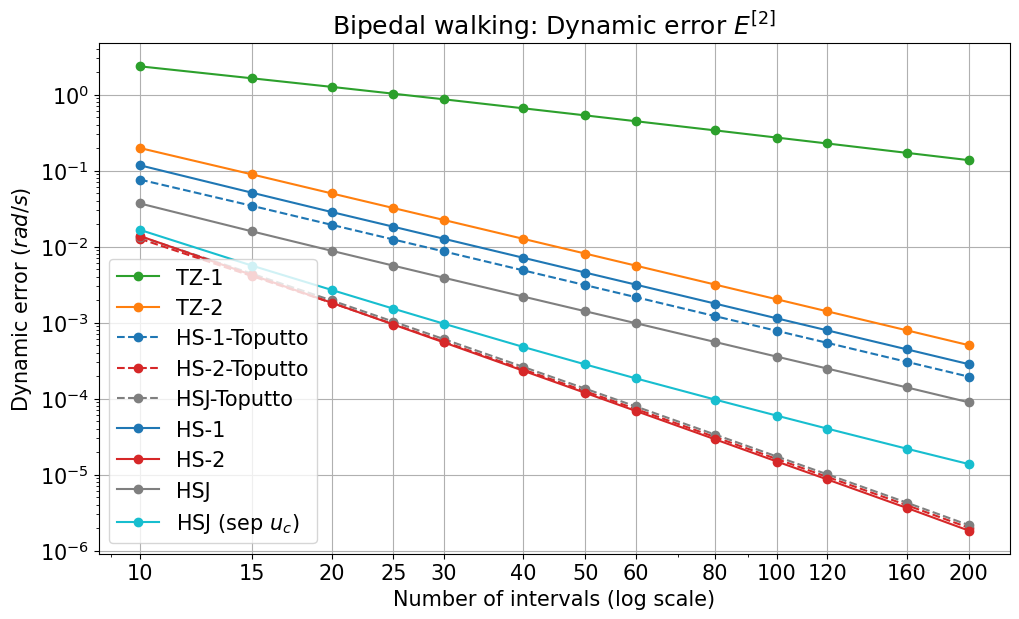

In [148]:
schemes_plot = ['trapz', 'trapz_mod', 'hs', 'hs_mod', 'hsj','hs_parab', 'hs_mod_parab', 'hsj_parab', 'hsj_parab_mod']
plt.figure(figsize=oct_fig_size)
for key in schemes_plot:
    plt.plot(results[key]['N_arr'],
             results[key][f'sum_dyn_err_2_array'],
             **scheme_kwargs(key, longlabel=False))
plt.grid()
plt.legend()
plt.yscale('log')
plt.xscale('log')
ticks = np.array(results[key]['N_arr'][::])

plt.xticks(ticks, labels=ticks)
plt.title(r'Bipedal walking: Dynamic error $E^{[2]}$')
plt.xlabel('Number of intervals (log scale)')
plt.ylabel('Dynamic error ($rad/s$)')
plt.tight_layout(pad = 0.0)
#plt.savefig('hsj_pics/5_link_Sum_second_order_dynamic_error_vs_interval_number.eps', format='eps')

schemes = ['hs_mod_parab','hs_parab', 'trapz', 'trapz_mod']
titles = ['2nd order Hermite Simpson', 'Hermite Simpson','Trapezoidal', '2nd order Trapezoidal']
plt.figure(figsize=oct_fig_size)
for ii in [2,3,1,0]:
    key = schemes[ii]
    plt.plot(results[key]['N_arr'], results[key][f'sum_twice_dyn_err_2_array'], marker = 'o', c = f'C{ii}',label = titles[ii])
plt.grid()
plt.legend()
plt.yscale('log')
plt.title('5-link biped twice integrated second order dynamic error $\Sigma |EE^{*[2]}_i|$')
plt.xlabel('Number of intervals')
plt.ylabel('Dynamic error ($rad$)')
plt.tight_layout(pad = 0.0)
#plt.savefig(f'5_link_Sum_twice_integ_second_order_dynamic_error_vs_interval_number.png', format='png')

schemes = ['hs_mod_parab','hs_parab', 'trapz', 'trapz_mod']
titles = ['Modified Hermite Simpson', 'Hermite Simpson','Trapezoidal', 'Modified Trapezoidal']
plt.figure(figsize=[14,8])
for ii in range(4):
    key = schemes[ii]
    plt.plot(results[key]['N_coll_arr'], results[key][f'sum_dyn_err_2_array'], marker = 'o',label = titles[ii])
plt.grid()
plt.legend()
plt.yscale('log')
plt.title('Added second order dynamic error')
plt.xlabel('Number of collocation points')
plt.ylabel('Dynamic error ($rad/s^2$)')
plt.savefig(f'5_link_Sum_second_order_dynamic_error_vs_collocation_points_number.eps', format='eps')

In [95]:
for scheme in schemes:
    key = scheme
    print('Problem:', key)
    N_arr = results[key]['N_arr']
    list_cpudt = []
    for N in N_arr:
        #print(f'\tN = {N}')
        list_cpudt.append(results[key][N]['cpudt'])
    results[key]['cpudt_array'] = np.array(list_cpudt)

Problem: hsj_parab_mod


### Saving Results

In [96]:
# Save results
with open('biped_results.pkl', 'wb') as f:
    pickle.dump(results, f)


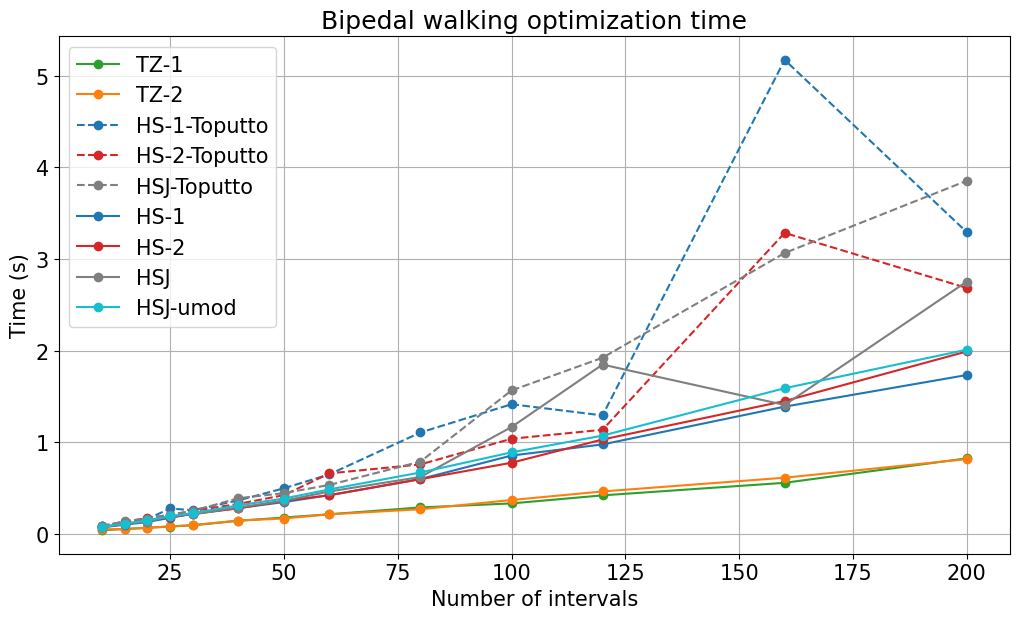

In [97]:
schemes = ['trapz', 'trapz_mod', 'hs', 'hs_mod', 'hsj','hs_parab', 'hs_mod_parab', 'hsj_parab', 'hsj_parab_mod']
#titles = ['2nd order Hermite Simpson', 'Hermite Simpson','Trapezoidal', '2nd order Trapezoidal']
plt.figure(figsize=oct_fig_size)
for key in schemes:
    plt.plot(results[key]['N_arr'], results[key][f'cpudt_array'],
             **scheme_kwargs(key, longlabel=False))
plt.grid()
plt.legend()
#plt.yscale('log')
plt.title('Bipedal walking optimization time')
plt.xlabel('Number of intervals')
plt.ylabel('Time (s)')
plt.tight_layout(pad = 0.0)

schemes = ['hs_mod_parab','hs_parab', 'trapz', 'trapz_mod']
titles = ['Modified Hermite Simpson', 'Hermite Simpson','Trapezoidal', 'Modified Trapezoidal']
plt.figure(figsize=[14,8])
for ii in range(4):
    key = schemes[ii]
    plt.plot(results[key]['N_coll_arr'], results[key][f'cpudt_array'], marker = 'o',label = titles[ii])
plt.grid()
plt.legend()
#plt.yscale('log')
plt.title('optimization time')
plt.xlabel('Number of collocation points')
plt.ylabel('time (s)')
plt.savefig(f'5 link optimization vs collocation points number.eps', format='eps')

In [98]:
for scheme in results.keys():
    key = scheme
    #for N in [25,50]:#results[key]['N_arr']:
    N = 25 if 'hs' in scheme else 50
    print('scheme:', scheme, 'N:', N,'\n\ttime:', results[key][N][f'cpudt'],
              '\n\tErr 1:', results[key][N]['sum_dyn_err_q'], '\n\tErr 2:', results[key][N]['sum_dyn_err_2'])

scheme: trapz N: 50 
	time: 0.1805401086807251 
	Err 1: 0.0024856057540546587 
	Err 2: 0.532846718757009
scheme: trapz_mod N: 50 
	time: 0.16994941234588623 
	Err 1: 4.429348247055145e-18 
	Err 2: 0.00809608557721397
scheme: hs N: 25 
	time: 0.27939043045043943 
	Err 1: 5.58506298634882e-05 
	Err 2: 0.012394863124266133
scheme: hs_mod N: 25 
	time: 0.20933613777160645 
	Err 1: 5.054041782935732e-19 
	Err 2: 0.0009540411712105983
scheme: hsj N: 25 
	time: 0.21320028305053712 
	Err 1: 5.442814227776942e-19 
	Err 2: 0.0010283534213428368
scheme: hs_parab N: 25 
	time: 0.1776427984237671 
	Err 1: 8.252705434608856e-05 
	Err 2: 0.018247602621604058
scheme: hs_mod_parab N: 25 
	time: 0.1855156898498535 
	Err 1: 6.220359117459362e-19 
	Err 2: 0.0009423598360356596
scheme: hsj_parab N: 25 
	time: 0.19530534744262695 
	Err 1: 5.442814227776942e-19 
	Err 2: 0.005610177748298496
scheme: hsj_parab_mod N: 25 
	time: 0.1945791244506836 
	Err 1: 6.220359117459362e-19 
	Err 2: 0.0015235858857749372


## Error de Integración

- Usar u(t) interpolado de una solución HS2 no-topputo de buen N
- Integrar numericamente con Scipy como solución correcta
- Integrar con los distintos esquemas y comparar

In [113]:
_N_ref_u = 677
_ref_u_scheme = 'hs_mod_parab'
_ref_sol = five_link(
            N = _N_ref_u,
            scheme = _ref_u_scheme,
            solve_repetitions = 1,
            t_end = 0.7,
            step_length = 0.5)

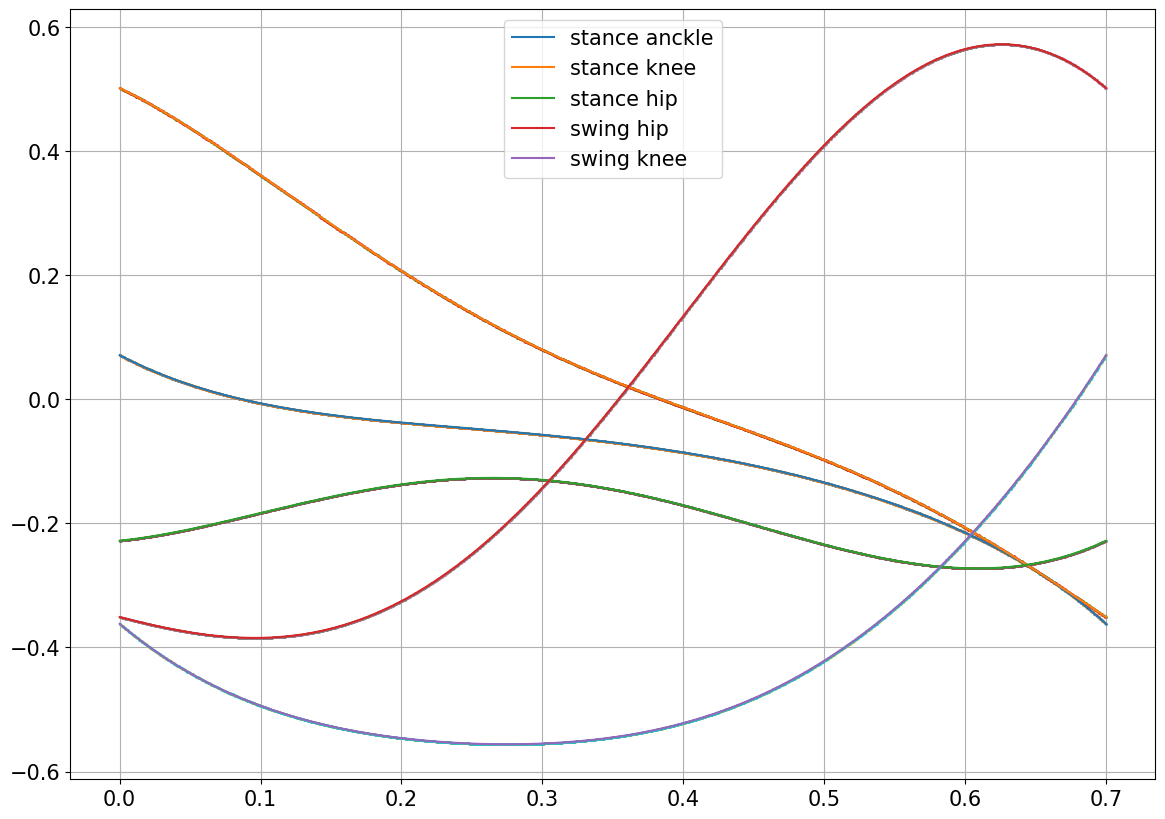

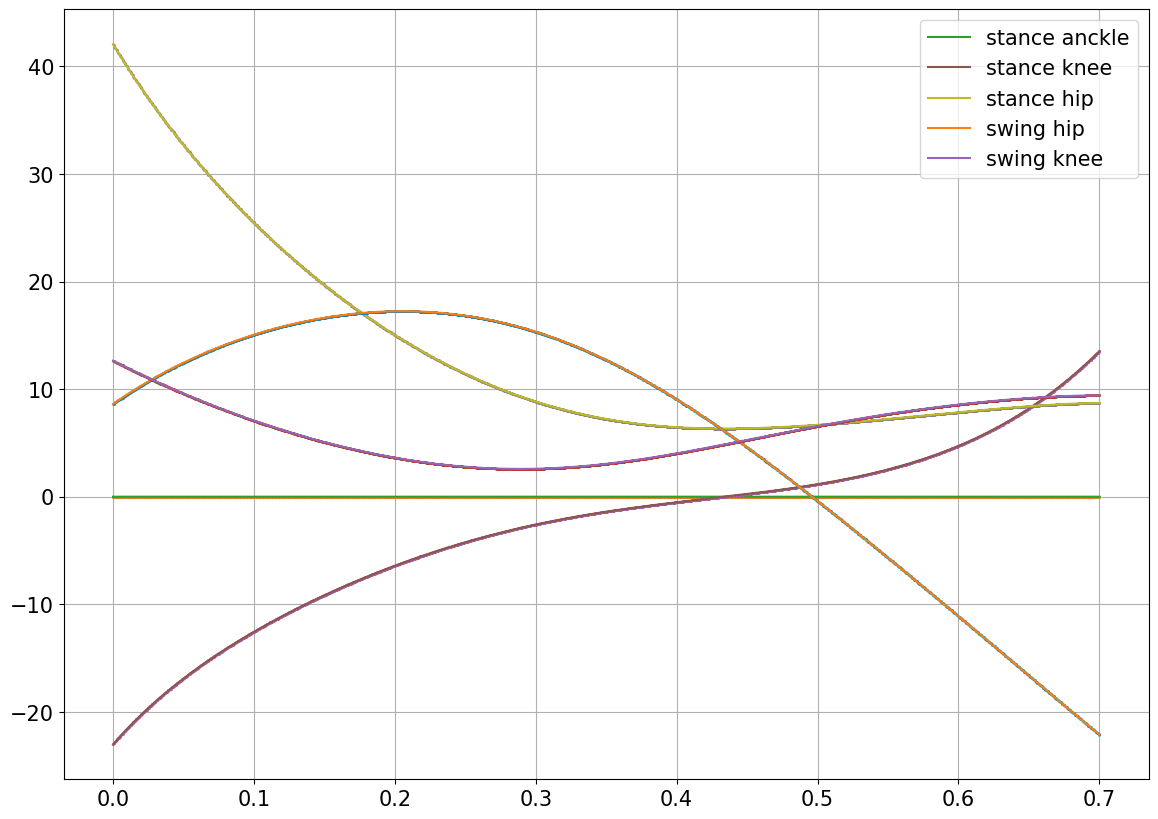

In [114]:
marker_size = 1
plt.figure(figsize=[14,10])
labels= ['stance anckle', 'stance knee', 'stance hip', 'swing hip', 'swing knee']
for ii in range(5):
    plt.plot(_ref_sol['t'],_ref_sol['q'][:,ii], 'o', ms = marker_size)#, label = labels[ii]
    try:
        plt.plot(_ref_sol['t_c'],_ref_sol['q_c'][:,ii], 'o', ms = marker_size)#label = labels[ii] + ' u_c'
    except KeyError:
        pass

n_interp = 3000
t_int_arr = np.linspace(0, _ref_sol['t'][-1], n_interp)
u_scheme, scheme_params = config_params_from_scheme(_ref_u_scheme, _ref_sol)
int_x, int_u = interpolated_array(
    _ref_sol['x'],
    _ref_sol['u'],
    _ref_sol['t'][-1]/(_ref_sol['t'].shape[0]-1),
    t_int_arr,
    params,
    F=None,
    X_dot=_ref_sol['x_d'],
    scheme=_ref_u_scheme,
    u_scheme=u_scheme,
    scheme_params=scheme_params,
)
for ii in range(5):
    plt.plot(t_int_arr,int_x[:,ii], label = labels[ii])
plt.grid()
plt.legend()

plt.figure(figsize=[14,10])
for ii in range(5):
    plt.plot(_ref_sol['t'],_ref_sol['u'][:,ii], 'o', ms = marker_size)#, label = labels[ii]
    try:
        plt.plot(_ref_sol['t_c'],_ref_sol['u_c'][:,ii], 'o', ms = marker_size)#label = labels[ii] + ' u_c'
    except KeyError:
        pass
    plt.plot(t_int_arr,int_u[:,ii], label = labels[ii])
plt.grid()
plt.legend()

In [115]:
def get_t_c_arr(scheme, N):
    if not 'parab' in scheme and not 'rk4' in scheme:
        return None
    
    t_arr = np.linspace(0, _ref_sol['t'][-1], N)
    if 'hsj' in scheme:
        t_c = (6 * t_arr[:-1] + 4*t_arr[1:])/10
    else:
        t_c = (t_arr[:-1] + t_arr[1:])/2
    return t_c

def generate_u_points(scheme, N):
    scheme_ref = _ref_u_scheme
    _N = _N_ref_u
    t_arr = np.linspace(0, _ref_sol['t'][-1], N)
    u_scheme, scheme_params = config_params_from_scheme(scheme_ref, _ref_sol)
    
    _, u_points = interpolated_array(
        _ref_sol['x'],
        _ref_sol['u'],
        _ref_sol['t'][-1]/(_ref_sol['t'].shape[0]-1),
        t_arr,
        params,
        F=None,
        X_dot=_ref_sol['x_d'],
        scheme=scheme_ref,
        u_scheme=u_scheme,
        scheme_params=scheme_params,
    )
    
    t_c = get_t_c_arr(scheme, N)
    
    if 'parab' in scheme or 'rk4' in scheme:
        _, u_c_points = interpolated_array(
            _ref_sol['x'],
            _ref_sol['u'],
            _ref_sol['t'][-1]/(_ref_sol['t'].shape[0]-1),
            t_c,
            params,
            F=None,
            X_dot=_ref_sol['x_d'],
            scheme=scheme_ref,
            u_scheme=u_scheme,
            scheme_params=scheme_params,
        )
    else:
        u_c_points = None
    return u_points, u_c_points

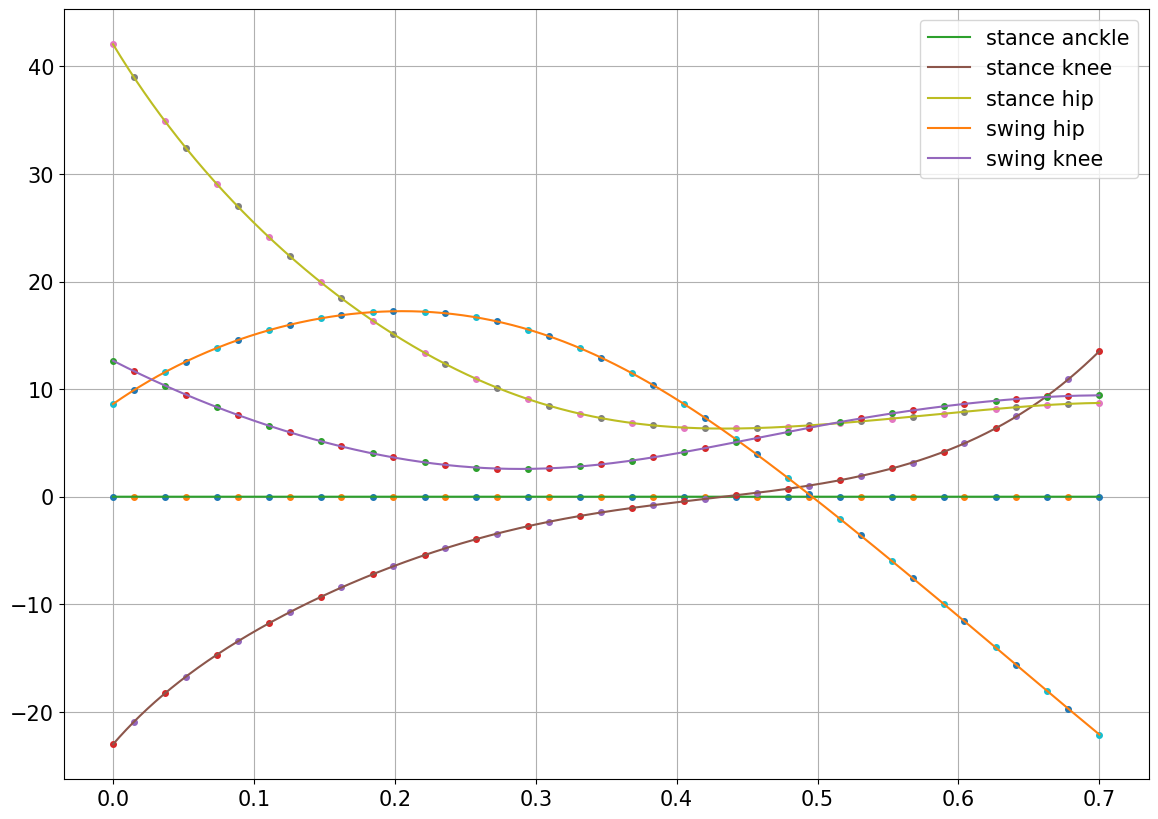

In [116]:
marker_size = 4
scheme = 'hsj_parab'
_n_points= 20
_t_points = np.linspace(0, _res['t'][-1], _n_points)
_t_points_c = get_t_c_arr(scheme, _n_points)
_u, _u_c = generate_u_points(scheme, _n_points)
plt.figure(figsize=[14,10])
for ii in range(5):
    plt.plot(_t_points,_u[:,ii], 'o', ms = marker_size)#, label = labels[ii]
    if 'parab' in scheme:
        plt.plot(_t_points_c,_u_c[:,ii], 'o', ms = marker_size)#label = labels[ii] + ' u_c'
    plt.plot(t_int_arr,int_u[:,ii], label = labels[ii])
plt.grid()
plt.legend()

In [117]:
import chords.piecewise as piecewise

In [118]:
from chords.piecewise import (integrate_euler ,
integrate_hs ,
integrate_hs_mod ,
integrate_hs_mod_parab ,
integrate_hs_parab ,
integrate_hsj_parab ,
integrate_hsj ,
integrate_rk4 ,
integrate_trapz ,
integrate_trapz_mod )

In [119]:
def integrate_scheme(scheme, x_0, u, F, dt, params, scheme_params = None):
    int_f_dic = {
        'euler' : integrate_euler ,
        'hs' : integrate_hs ,
        'hs_mod' : integrate_hs_mod ,
        'hs_mod_parab' : integrate_hs_mod_parab ,
        'hs_parab' : integrate_hs_parab ,
        'hsj_parab' : integrate_hsj_parab ,
        'hsj' : integrate_hsj ,  
        'rk4' : integrate_rk4 ,
        'trapz' : integrate_trapz ,
        'trapz_mod' : integrate_trapz_mod ,
        'hsj_parab_mod' : integrate_hsj_parab,
    }
    f_integ = int_f_dic[scheme]
    if scheme in ['euler']:
        return f_integ(x_0, u, F, dt, params)
    
    root_kwargs = {'tol':1e-12}
    if scheme == 'rk4':
        return f_integ(x_0, u, F, dt, params, scheme_params)
    elif 'parab' in scheme:
        return f_integ(x_0, u, F, dt, params, scheme_params, root_kwargs)
    else:
        return f_integ(x_0, u, F, dt, params, root_kwargs)

In [120]:
x_0 = _ref_sol['x'][0,:]

In [121]:
from scipy.integrate import solve_ivp

In [122]:
from chords.piecewise import _newpoint_u, interp_2d

In [123]:
def F_t_x(t, x):
    U = _ref_sol['u']
    u_scheme, scheme_params = config_params_from_scheme(_ref_u_scheme, _ref_sol)
    h = _ref_sol['t'][-1]/_N_ref_u
    u_point = _newpoint_u(U, h, t, u_scheme, scheme_params)
    x_dot = F_nump(x, u_point, params)
    return x_dot

In [125]:
scipy_sol = solve_ivp(F_t_x, [0, _res['t'][-1]], x_0, 'BDF', atol= 0, rtol = 1e-10)

x_raw = scipy_sol.y.T
t_raw = scipy_sol.t

t_points_ref = np.linspace(0, t_raw[-1], t_raw.shape[0]*4)
x_ref = interp_2d(t_points_ref, t_raw, x_raw)
q_ref = x_ref[:,:5]
v_ref = x_ref[:,5:]
 
N_ref =  x_ref.shape[0]
u_ref, u_c_ref = generate_u_points('hs_mod_parab', N_ref)
dt_ref = _res['t'][-1]/(N_ref-1)

ref_scipy = {
    'x':x_ref,
    'q':q_ref,
    'v':v_ref,
    't':t_points_ref,
    'N': N_ref,
    'u': u_ref,
    'u_c': u_c_ref,
    'dt':dt_ref
}

In [126]:
N_ref = 6977
_u, _u_c = generate_u_points('rk4', N_ref)
_dt = _res['t'][-1]/(N_ref-1)

x_ref = integrate_scheme('rk4', x_0, _u, F_nump, _dt, params, {"u_c":_u_c})[:-1,:]
t_points_ref = np.linspace(0, _res['t'][-1],N_ref)

q_ref = x_ref[:,:5]
v_ref = x_ref[:,5:]
 
u_ref, u_c_ref = _u, _u_c
dt_ref = _dt

ref = {
    'x':x_ref,
    'q':q_ref,
    'v':v_ref,
    't':t_points_ref,
    'N': N_ref,
    'u': u_ref,
    'u_c': u_c_ref,
    'dt':dt_ref
}

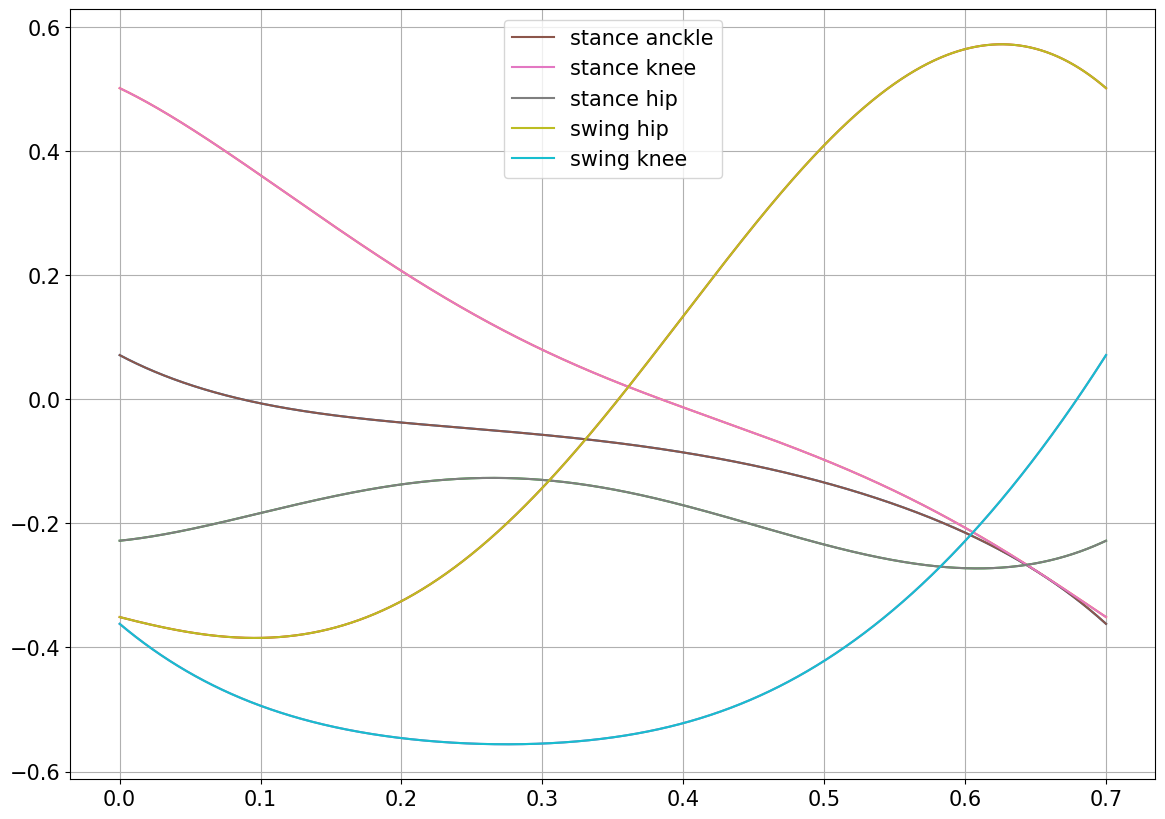

In [127]:
marker_size = 4
plt.figure(figsize=[14,10])
labels= ['stance anckle', 'stance knee', 'stance hip', 'swing hip', 'swing knee']
for ii in range(5):
    plt.plot(t_points_ref,q_ref[:,ii])#, label = labels[ii]
    #plt.plot(_res['t_c'],_res['q_c'][:,ii], 'o', ms = marker_size)#label = labels[ii] + ' u_c'

for ii in range(5):
    plt.plot(t_int_arr,int_x[:,ii], label = labels[ii])
plt.grid()
plt.legend()

integrate_hs_mod_parab()

scheme = 'hs_mod_parab'
N_ref =  5099
u_ref, u_c_ref = generate_u_points(scheme, N_ref)
dt_ref = _res['t'][-1]/(N_ref-1)

x_ref = integrate_scheme(scheme, x_0, u_ref, F_nump, dt_ref, params, {'u_c': u_c_ref})[:-1,:]

q_ref = x_ref[:,:5]
v_ref = x_ref[:,5:]

t_points_ref = np.linspace(0, _res['t'][-1],N_ref)
t_points_c_ref = get_t_c_arr(scheme, N_ref)

In [128]:
  
def generate_q_points_ref(N, ref):
    scheme = 'hs_scipy'
    u_scheme = 'lin'
    scheme_params = {'u_c': ref['u_c']}
    
    t_arr = np.linspace(0, ref['t'][-1], N)
    #u_scheme, scheme_params = config_params_from_scheme(scheme, _res)
    
    x_points, _ = interpolated_array(
        X = ref['x'],
        U = ref['u'],
        h = ref['dt'],
        t_array = t_arr,
        params = params,
        F=F_nump,
        X_dot=None,
        scheme=scheme,
        u_scheme=u_scheme,
        scheme_params=scheme_params,
    )
    return x_points[:,:5]
    

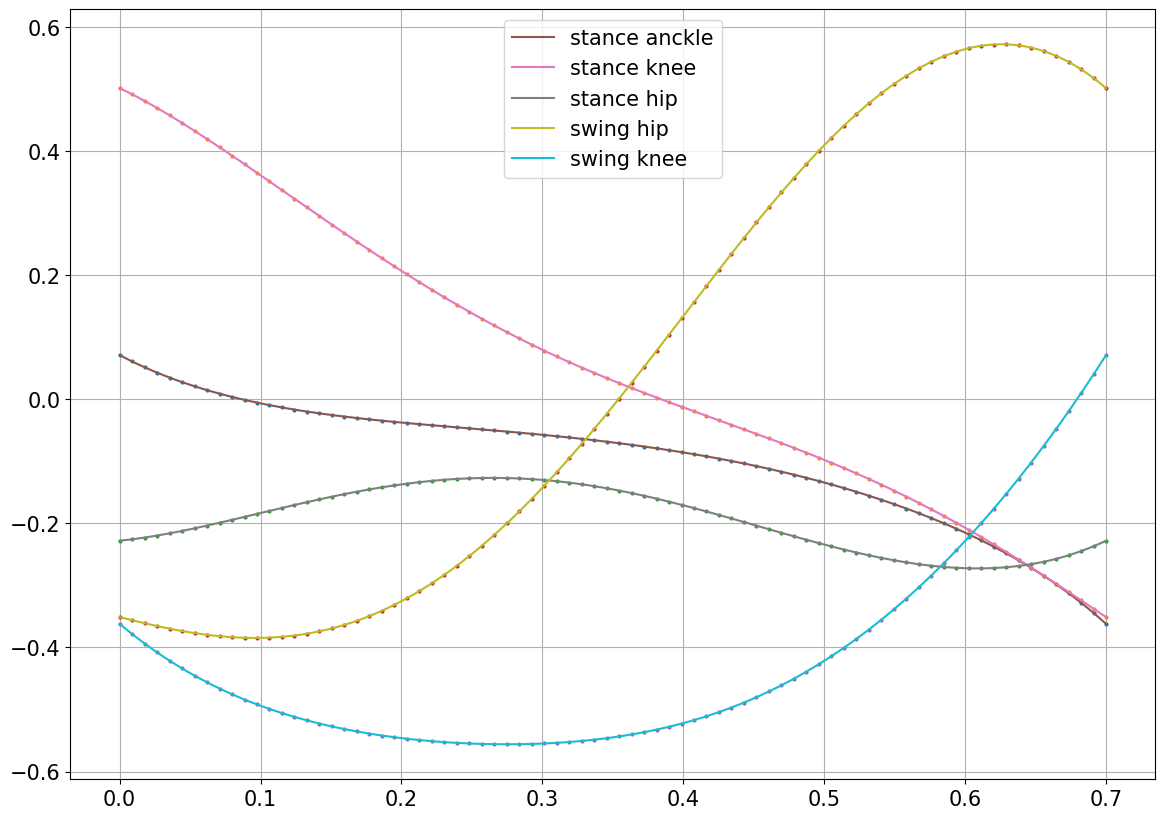

In [129]:
scheme = 'hs_parab'
_N = 80
_u, _u_c = generate_u_points(scheme, _N)
_dt = _res['t'][-1]/(_N-1)
_integ = integrate_scheme(scheme, x_0, _u, F_nump, _dt, params, {"u_c":_u_c})[:-1,:]
_q = _integ[:,:5]
_v = _integ[:,5:]

marker_size = 2
_t_points = np.linspace(0, _res['t'][-1],_N)
_t_points_c = get_t_c_arr(scheme, _N)
_u, _u_c = generate_u_points('hs_mod_parab', _N)

q_ref_points=generate_q_points_ref(_N, ref)

plt.figure(figsize=[14,10])
labels= ['stance anckle', 'stance knee', 'stance hip', 'swing hip', 'swing knee']
for ii in range(5):
    plt.plot(_t_points,_q[:,ii], 'o', ms = marker_size)#, label = labels[ii]
    plt.fill_between(_t_points, _q[:,ii],q_ref_points[:,ii], alpha = 0.5)
    #plt.plot(_t_points,q_ref_points[:,ii], 'o', c = 'k', ms = marker_size, label = 'qref_points')
    #plt.plot(_res['t_c'],_res['q_c'][:,ii], 'o', ms = marker_size)#label = labels[ii] + ' u_c'

for ii in range(5):
    plt.plot(ref['t'],ref['q'][:,ii], label = labels[ii])
plt.grid()
plt.legend()

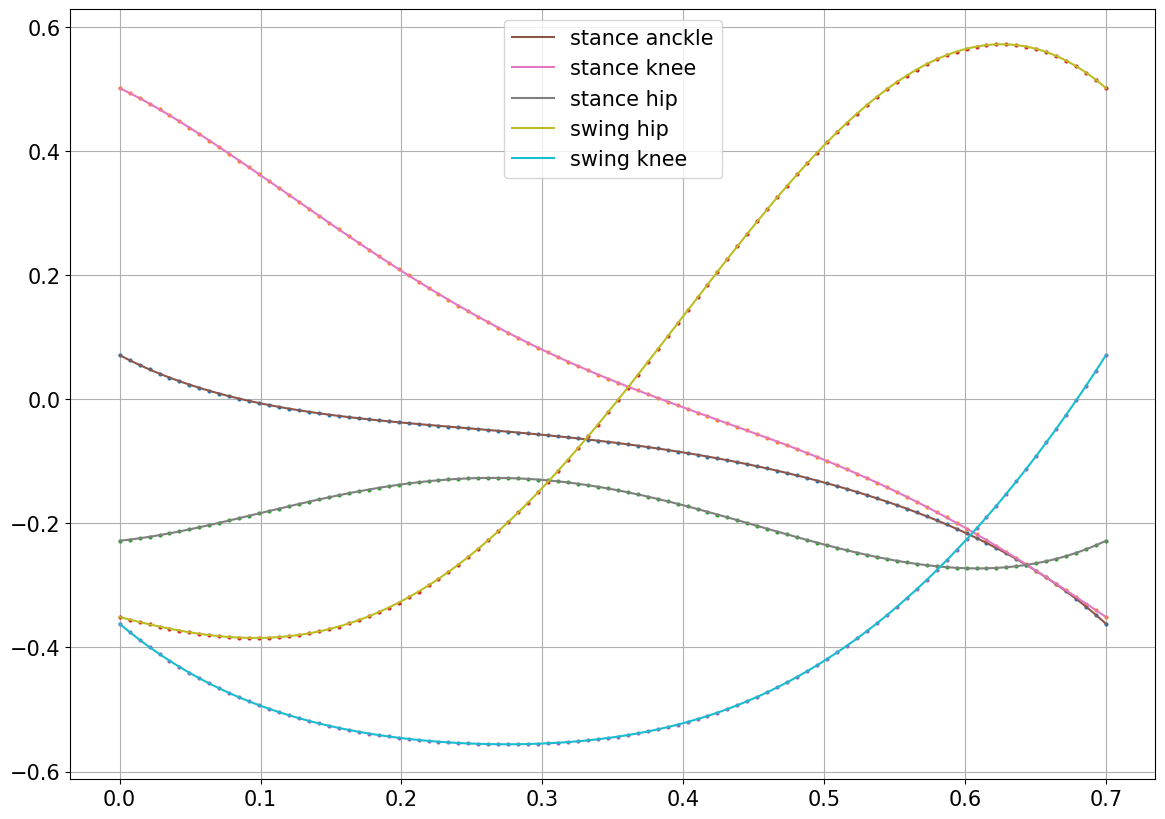

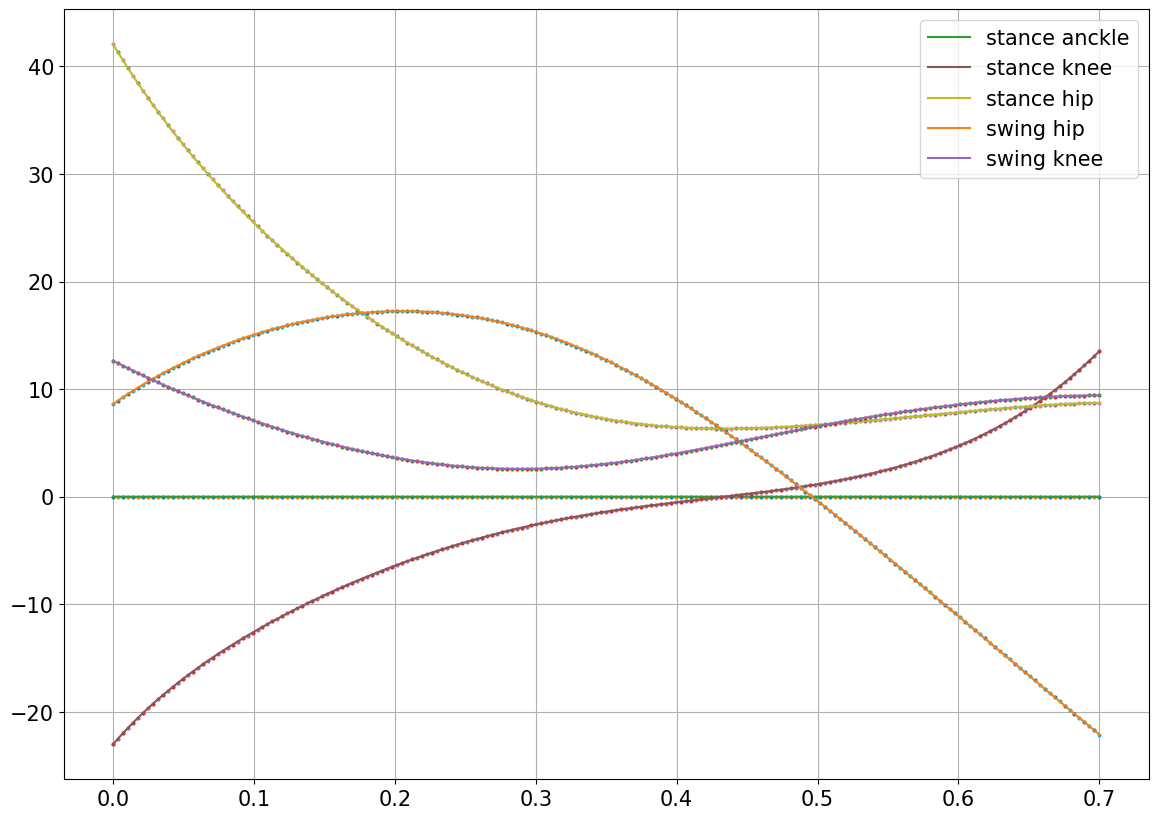

In [130]:
scheme = 'hs_parab'
_N = 100
_u, _u_c = generate_u_points(scheme, _N)
_dt = _res['t'][-1]/(_N-1)
_integ = integrate_scheme(scheme, x_0, _u, F_nump, _dt, params, {"u_c":_u_c})[:-1,:]

marker_size = 2
_t_points = np.linspace(0, _res['t'][-1],_N)
_t_points_c = get_t_c_arr(scheme, _N)
_u, _u_c = generate_u_points(scheme, _N)
_q = _integ[:,:5]
_v = _integ[:,5:]

q_ref_points=generate_q_points_ref(_N, ref)

plt.figure(figsize=[14,10])
labels= ['stance anckle', 'stance knee', 'stance hip', 'swing hip', 'swing knee']
for ii in range(5):
    plt.plot(_t_points,_q[:,ii], 'o', ms = marker_size)#, label = labels[ii]
    plt.fill_between(_t_points, _q[:,ii],q_ref_points[:,ii], alpha = 0.5)
    #plt.plot(_res['t_c'],_res['q_c'][:,ii], 'o', ms = marker_size)#label = labels[ii] + ' u_c'

for ii in range(5):
    plt.plot(ref['t'],ref['q'][:,ii], label = labels[ii])
plt.grid()
plt.legend()


plt.figure(figsize=[14,10])
for ii in range(5):
    plt.plot(_t_points,_u[:,ii], 'o', ms = marker_size)#, label = labels[ii]
    if 'parab' in scheme:
        plt.plot(_t_points_c,_u_c[:,ii], 'o', ms = marker_size)#label = labels[ii] + ' u_c'
    plt.plot(t_int_arr,int_u[:,ii], label = labels[ii])
plt.grid()
plt.legend()

In [133]:
@lru_cache(maxsize=None)
def _diff(scheme, _N):
    _u, _u_c = generate_u_points(scheme, _N)
    _dt = _res['t'][-1]/(_N-1)
    _integ = integrate_scheme(scheme, x_0, _u, F_nump, _dt, params, {"u_c":_u_c})[:-1,:]

    _t_points = np.linspace(0, _res['t'][-1],_N)
    _q = _integ[:,:5]
    _v = _integ[:,5:]

    q_ref_points=generate_q_points_ref(_N, ref)
    diff = np.sum(np.abs(_q - q_ref_points), axis=1)
    
    return diff, _t_points

    

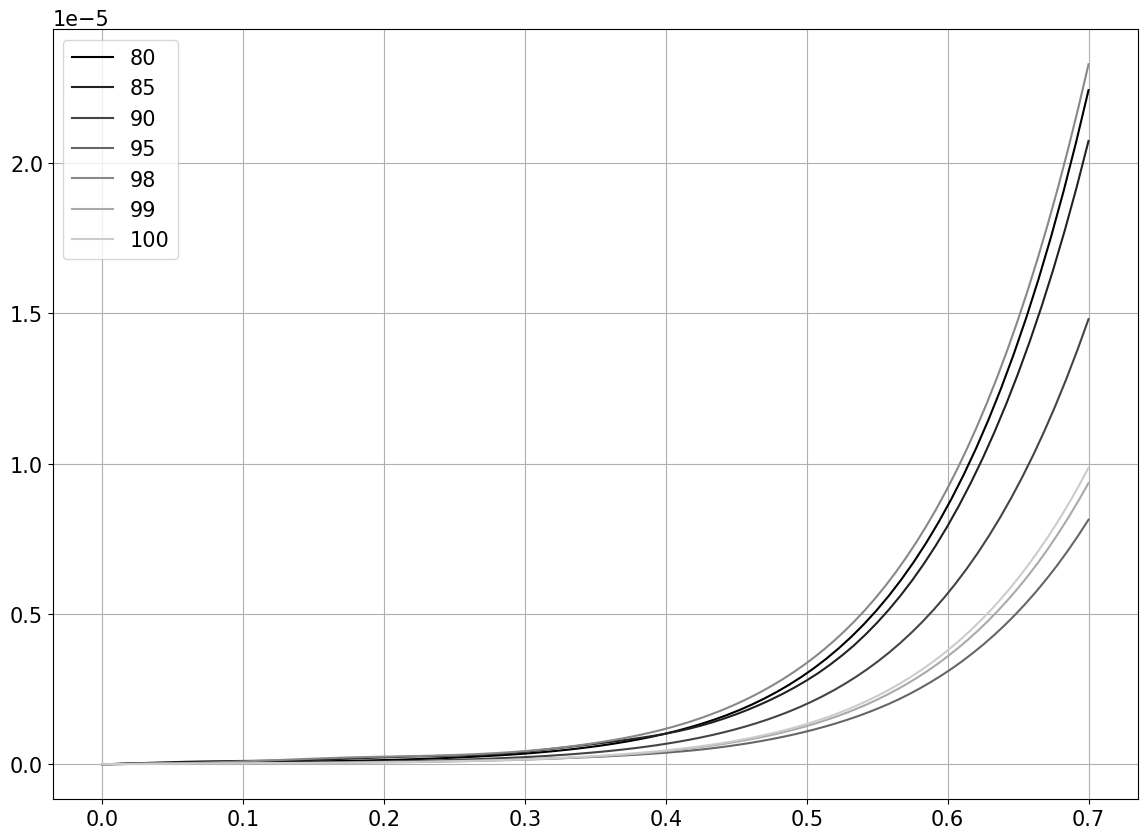

In [134]:
_scheme = 'hs_parab'
plt.figure(figsize=[14,10])
marker_size=3

_n_arr = [80,85,90,95,98,99,100]
_alph = np.linspace(0, 0.8, len(_n_arr))

for ii in range(len(_n_arr)):
    _e, _t = _diff(_scheme, _n_arr[ii])
    plt.plot(_t,_e, c = str(_alph[ii]), ms = marker_size, label = _n_arr[ii])#, label = labels[ii]
plt.grid()
plt.legend()

In [135]:
@lru_cache(maxsize=None)
def integration_error_q(scheme, N): 
    _u, _u_c = generate_u_points(scheme, N)
    _dt = _res['t'][-1]/(N-1)
    cput0 = time.time()
    _integ = integrate_scheme(scheme, x_0, _u, F_nump, _dt, params, {"u_c":_u_c})[:-1,:]
    cput1 = time.time()
    cpudt = (cput1 - cput0)
    _t_points = np.linspace(0, _res['t'][-1],N)
    
    _q = _integ[:,:5]
    _v = _integ[:,5:]
    q_ref_points=generate_q_points_ref(N, ref)
    err = np.abs(_q-q_ref_points)
    
    return np.trapz(err.T, _t_points), cpudt

In [123]:
# If Loading a saved run:
with open('biped_results_common_u.pkl', 'rb') as f:
    integ_results = pickle.load(f)
schemes = [ii for ii in integ_results.keys()]

In [136]:
schemes = [ii for ii in results.keys()]+['rk4']
#N_err = [5, 6, 8, 10, 15, 20, 25, 30, 40, 50, 60, 80, 90, 95, 98, 99, 100,101, 102, 105,
#         110, 120, 160, 180, 190, 196, 198, 199, 200, 201, 202, 204, 210, 220, 240, 320]
N_err = [5, 6, 8, 10, 15, 20, 25, 30, 40, 50, 60, 80, 100, 120, 160, 200]
integ_results = {}
for scheme in schemes:
    print('Problem:', scheme, f' scheme # {schemes.index(scheme)+1} of total {len(schemes)} schemes')
    _err = []
    _cpudt = []
    for ii in N_err:
        print(f'\tN = {ii} , ', f' Number # {N_err.index(ii)+1} of total {len(N_err)} numbers', time.strftime('%H:%M:%S ', time.localtime(time.time())))
        
        _i_err, cpudt = integration_error_q(scheme, ii)
        _err.append(list(_i_err))
        _cpudt.append(cpudt)
    _err = np.array(_err)
    _cpudt = np.array(_cpudt)
    integ_results[scheme] = {
        'N_arr': N_err,
        'cpudt_array' : _cpudt,
        'error': _err,
        'error_sum': np.sum(_err, axis = 1)
    }

Problem: trapz  scheme # 1 of total 10 schemes
	N = 5 ,   Number # 1 of total 16 numbers 14:02:30 
	N = 6 ,   Number # 2 of total 16 numbers 14:02:33 
	N = 8 ,   Number # 3 of total 16 numbers 14:02:35 
	N = 10 ,   Number # 4 of total 16 numbers 14:02:37 
	N = 15 ,   Number # 5 of total 16 numbers 14:02:39 
	N = 20 ,   Number # 6 of total 16 numbers 14:02:41 
	N = 25 ,   Number # 7 of total 16 numbers 14:02:44 
	N = 30 ,   Number # 8 of total 16 numbers 14:02:46 
	N = 40 ,   Number # 9 of total 16 numbers 14:02:48 
	N = 50 ,   Number # 10 of total 16 numbers 14:02:51 
	N = 60 ,   Number # 11 of total 16 numbers 14:02:54 
	N = 80 ,   Number # 12 of total 16 numbers 14:02:56 
	N = 100 ,   Number # 13 of total 16 numbers 14:02:59 
	N = 120 ,   Number # 14 of total 16 numbers 14:03:02 
	N = 160 ,   Number # 15 of total 16 numbers 14:03:06 
	N = 200 ,   Number # 16 of total 16 numbers 14:03:09 
Problem: trapz_mod  scheme # 2 of total 10 schemes
	N = 5 ,   Number # 1 of total 16 numbers 14:0

	N = 6 ,   Number # 2 of total 16 numbers 14:09:38 
	N = 8 ,   Number # 3 of total 16 numbers 14:09:40 
	N = 10 ,   Number # 4 of total 16 numbers 14:09:42 
	N = 15 ,   Number # 5 of total 16 numbers 14:09:44 
	N = 20 ,   Number # 6 of total 16 numbers 14:09:46 
	N = 25 ,   Number # 7 of total 16 numbers 14:09:48 
	N = 30 ,   Number # 8 of total 16 numbers 14:09:51 
	N = 40 ,   Number # 9 of total 16 numbers 14:09:53 
	N = 50 ,   Number # 10 of total 16 numbers 14:09:55 
	N = 60 ,   Number # 11 of total 16 numbers 14:09:57 
	N = 80 ,   Number # 12 of total 16 numbers 14:09:59 
	N = 100 ,   Number # 13 of total 16 numbers 14:10:01 
	N = 120 ,   Number # 14 of total 16 numbers 14:10:04 
	N = 160 ,   Number # 15 of total 16 numbers 14:10:06 
	N = 200 ,   Number # 16 of total 16 numbers 14:10:08 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


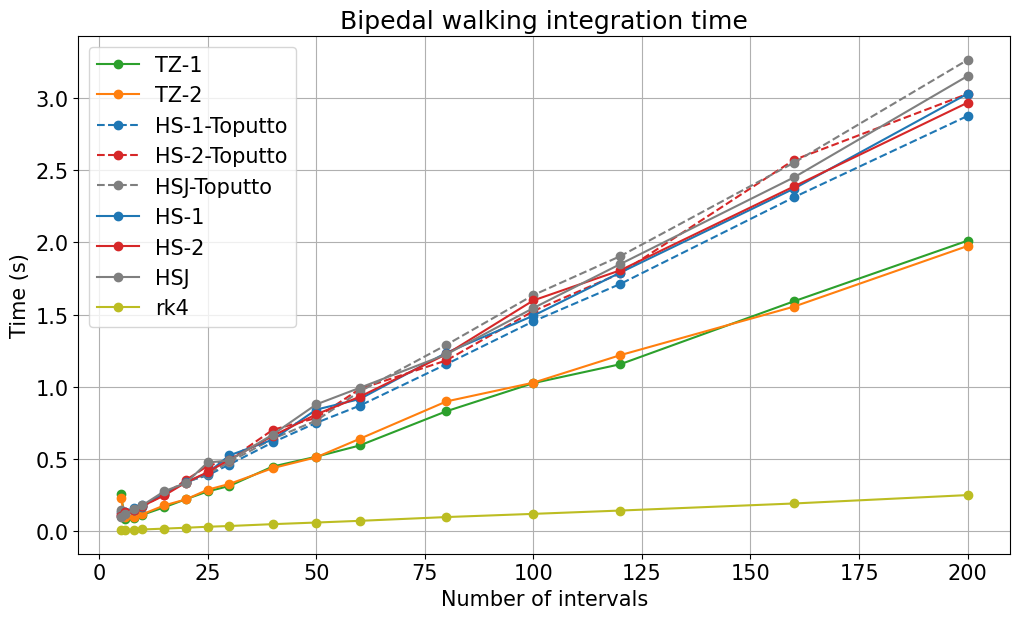

In [139]:
schemes = ['trapz', 'trapz_mod', 'hs', 'hs_mod', 'hsj','hs_parab', 'hs_mod_parab', 'hsj_parab','rk4']
#titles = ['2nd order Hermite Simpson', 'Hermite Simpson','Trapezoidal', '2nd order Trapezoidal']
plt.figure(figsize=oct_fig_size)
for key in schemes:
    plt.plot(integ_results[key]['N_arr'], integ_results[key][f'cpudt_array'],
             **scheme_kwargs(key, longlabel=False))
plt.grid()
plt.legend()
#plt.yscale('log')
plt.title('Bipedal walking integration time')
plt.xlabel('Number of intervals')
plt.ylabel('Time (s)')
plt.tight_layout(pad = 0.0)
#plt.savefig('hsj_pics/5_link_u_ref_t_vs_interval_number.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


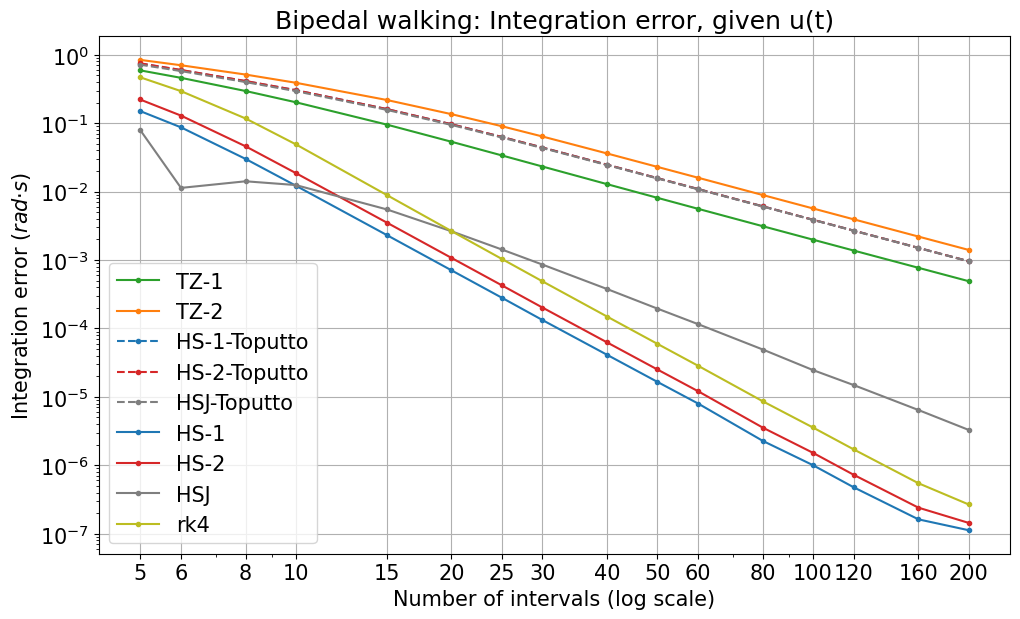

In [145]:
schemes_plot = ['trapz', 'trapz_mod', 'hs', 'hs_mod', 'hsj','hs_parab', 'hs_mod_parab', 'hsj_parab', 'rk4']
#schemes_plot = ['hs', 'hs_parab','rk4']
plt.figure(figsize=oct_fig_size)
for key in schemes_plot:
    plt.plot(integ_results[key]['N_arr'],
             integ_results[key]['error_sum'],
             ms = 3,
             **scheme_kwargs(key, longlabel=False))
plt.grid()
plt.legend()
plt.yscale('log')
plt.xscale('log')
ticks = np.array(integ_results[key]['N_arr'][::])
#ticks = np.array([5, 6, 8, 10, 15, 20, 25, 30, 40, 50, 60, 80, 100, 120, 160, 200, 240, 320])
plt.xticks(ticks, labels=ticks)

plt.title(r'Bipedal walking: Integration error, given u(t)')
plt.xlabel('Number of intervals (log scale)')
plt.ylabel('Integration error ($rad·s$)')
plt.tight_layout(pad = 0.0)

#plt.savefig('hsj_pics/5_link_integration_error_vs_interval_number.eps', format='eps')

### Saving results

In [92]:
# Save results
with open('biped_results_common_u.pkl', 'wb') as f:
    pickle.dump(integ_results, f)


## Error de Integración: ejercicio 2

- Usar u(t) = 0
- Integrar numericamente con Scipy como solución correcta
- Integrar con los distintos esquemas y comparar

In [127]:
def generate_u_points_zero(scheme, N):
    u_points = np.zeros([N, 5])
    
    if 'parab' in scheme or 'rk4' in scheme:
        u_c_points =  np.zeros([N-1, 5])
    else:
        u_c_points = None
    return u_points, u_c_points

def F_t_x_zero(t, x):
    u0 = np.zeros(5)
    x_dot = F_nump(x, u0, params)
    return x_dot

In [128]:
scipy_sol_zero = solve_ivp(F_t_x_zero, [0, _res['t'][-1]], x_0, 'BDF', atol= 0, rtol = 1e-10)

x_raw = scipy_sol_zero.y.T
t_raw = scipy_sol_zero.t

t_points_ref = np.linspace(0, t_raw[-1], t_raw.shape[0]*4)
x_ref = interp_2d(t_points_ref, t_raw, x_raw)
q_ref = x_ref[:,:5]
v_ref = x_ref[:,5:]
 
N_ref =  x_ref.shape[0]
u_ref, u_c_ref = generate_u_points('hs_mod_parab', N_ref)
dt_ref = _res['t'][-1]/(N_ref-1)

ref_zero = {
    'x':x_ref,
    'q':q_ref,
    'v':v_ref,
    't':t_points_ref,
    'N': N_ref,
    'u': u_ref,
    'u_c': u_c_ref,
    'dt':dt_ref
}

In [129]:
N_ref = 7001
_u, _u_c = generate_u_points_zero('rk4', N_ref)
_dt = _res['t'][-1]/(N_ref-1)

x_ref = integrate_scheme('rk4', x_0, _u, F_nump, _dt, params, {"u_c":_u_c})[:-1,:]
t_points_ref = np.linspace(0, _res['t'][-1],N_ref)

q_ref = x_ref[:,:5]
v_ref = x_ref[:,5:]
 
u_ref, u_c_ref = generate_u_points('hs_mod_parab', N_ref)
dt_ref = _res['t'][-1]/(N_ref-1)

ref_zero = {
    'x':x_ref,
    'q':q_ref,
    'v':v_ref,
    't':t_points_ref,
    'N': N_ref,
    'u': u_ref,
    'u_c': u_c_ref,
    'dt':dt_ref
}

In [130]:
def generate_q_points_ref_zero(N, ref):
    scheme = 'hs_scipy'
    u_scheme = 'lin'
    scheme_params = {'u_c': ref_zero['u_c']}
    
    t_arr = np.linspace(0, ref_zero['t'][-1], N)
    
    x_points, _ = interpolated_array(
        X = ref_zero['x'],
        U = ref_zero['u'],
        h = ref_zero['dt'],
        t_array = t_arr,
        params = params,
        F=F_nump,
        X_dot=None,
        scheme=scheme,
        u_scheme=u_scheme,
        scheme_params=scheme_params,
    )
    return x_points[:,:5]

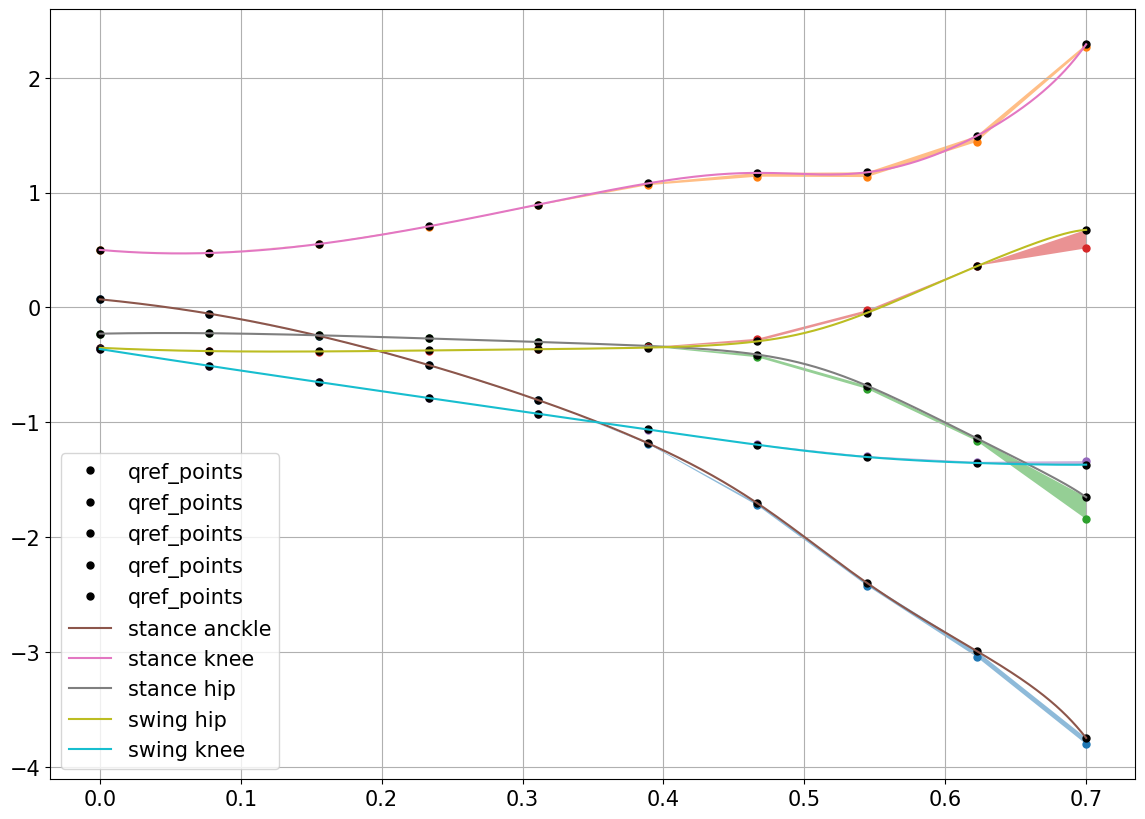

In [131]:
scheme = 'trapz_mod'
_N = 10
_u, _u_c = generate_u_points_zero(scheme, _N)
_dt = _res['t'][-1]/(_N-1)
_integ = integrate_scheme(scheme, x_0, _u, F_nump, _dt, params, {"u_c":_u_c})[:-1,:]
_q = _integ[:,:5]
_v = _integ[:,5:]

marker_size = 5
_t_points = np.linspace(0, _res['t'][-1],_N)
_t_points_c = get_t_c_arr(scheme, _N)
_u, _u_c = generate_u_points_zero('hs_mod_parab', _N)

q_ref_points=generate_q_points_ref_zero(_N, ref)

plt.figure(figsize=[14,10])
labels= ['stance anckle', 'stance knee', 'stance hip', 'swing hip', 'swing knee']
for ii in range(5):
    plt.plot(_t_points,_q[:,ii], 'o', ms = marker_size)#, label = labels[ii]
    plt.fill_between(_t_points, _q[:,ii],q_ref_points[:,ii], alpha = 0.5)
    plt.plot(_t_points,q_ref_points[:,ii], 'o', c = 'k', ms = marker_size, label = 'qref_points')
    #plt.plot(_res['t_c'],_res['q_c'][:,ii], 'o', ms = marker_size)#label = labels[ii] + ' u_c'

for ii in range(5):
    plt.plot(t_points_ref,q_ref[:,ii], label = labels[ii])
plt.grid()
plt.legend()

In [132]:
@lru_cache(maxsize=None)
def integration_error_q_zero(scheme, N): 
    _u, _u_c = generate_u_points_zero(scheme, N)
    _dt = _res['t'][-1]/(N-1)
    cput0 = time.time()
    _integ = integrate_scheme(scheme, x_0, _u, F_nump, _dt, params, {"u_c":_u_c})[:-1,:]
    cput1 = time.time()
    cpudt = (cput1 - cput0)
    _t_points = np.linspace(0, _res['t'][-1],N)
    
    _q = _integ[:,:5]
    _v = _integ[:,5:]
    q_ref_points=generate_q_points_ref_zero(N, ref)
    err = np.abs(_q-q_ref_points)
    
    return np.trapz(err.T, _t_points), cpudt

In [133]:
# If Loading a saved run:
with open('biped_results_common_u_zero.pkl', 'rb') as f:
    integ_results_zero = pickle.load(f)
schemes = [ii for ii in integ_results.keys()]

In [123]:
schemes = [ii for ii in results.keys()]+['rk4']
#N_err = [5, 6, 8, 10, 15, 20, 25, 30, 40, 50, 60, 80, 90, 95, 98, 99, 100,101, 102, 105,
#         110, 120, 160, 180, 190, 196, 198, 199, 200, 201, 202, 204, 210, 220, 240, 320]
N_err = [5, 6, 8, 10, 15, 20, 25, 30, 40, 50, 60, 80, 100, 120, 160, 200]
integ_results_zero = {}
for scheme in schemes:
    print('Problem:', scheme, f' scheme # {schemes.index(scheme)+1} of total {len(schemes)} schemes')
    _err = []
    _cpudt = []
    for ii in N_err:
        print(f'\tN = {ii} , ', f' Number # {N_err.index(ii)+1} of total {len(N_err)} numbers', time.strftime('%H:%M:%S ', time.localtime(time.time())))
        
        _i_err, cpudt = integration_error_q_zero(scheme, ii)
        _err.append(list(_i_err))
        _cpudt.append(cpudt)
    _err = np.array(_err)
    _cpudt = np.array(_cpudt)
    integ_results_zero[scheme] = {
        'N_arr': N_err,
        'cpudt_array' : _cpudt,
        'error': _err,
        'error_sum': np.sum(_err, axis = 1)
    }

Problem: trapz  scheme # 1 of total 9 schemes
	N = 5 ,   Number # 1 of total 16 numbers 15:04:18 
	N = 6 ,   Number # 2 of total 16 numbers 15:04:20 
	N = 8 ,   Number # 3 of total 16 numbers 15:04:22 
	N = 10 ,   Number # 4 of total 16 numbers 15:04:24 
	N = 15 ,   Number # 5 of total 16 numbers 15:04:27 
	N = 20 ,   Number # 6 of total 16 numbers 15:04:29 
	N = 25 ,   Number # 7 of total 16 numbers 15:04:31 
	N = 30 ,   Number # 8 of total 16 numbers 15:04:33 
	N = 40 ,   Number # 9 of total 16 numbers 15:04:36 
	N = 50 ,   Number # 10 of total 16 numbers 15:04:38 
	N = 60 ,   Number # 11 of total 16 numbers 15:04:41 
	N = 80 ,   Number # 12 of total 16 numbers 15:04:43 
	N = 100 ,   Number # 13 of total 16 numbers 15:04:46 
	N = 120 ,   Number # 14 of total 16 numbers 15:04:49 
	N = 160 ,   Number # 15 of total 16 numbers 15:04:53 
	N = 200 ,   Number # 16 of total 16 numbers 15:04:56 
Problem: trapz_mod  scheme # 2 of total 9 schemes
	N = 5 ,   Number # 1 of total 16 numbers 15:05:

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


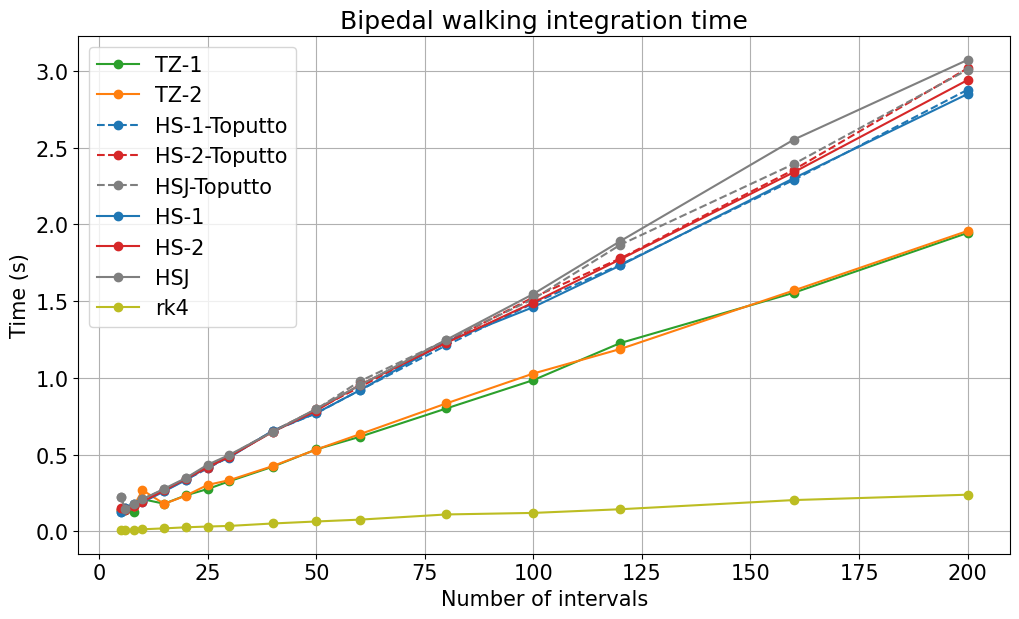

In [184]:
schemes = ['trapz', 'trapz_mod', 'hs', 'hs_mod', 'hsj','hs_parab', 'hs_mod_parab', 'hsj_parab','rk4']
#titles = ['2nd order Hermite Simpson', 'Hermite Simpson','Trapezoidal', '2nd order Trapezoidal']
plt.figure(figsize=oct_fig_size)
for key in schemes:
    plt.plot(integ_results_zero[key]['N_arr'], integ_results_zero[key][f'cpudt_array'],
             **scheme_kwargs(key, longlabel=False))
plt.grid()
plt.legend()
#plt.yscale('log')
plt.title('Bipedal walking integration time')
plt.xlabel('Number of intervals')
plt.ylabel('Time (s)')
plt.tight_layout(pad = 0.0)
#plt.savefig('hsj_pics/5_link_u_0_t_vs_interval_number.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


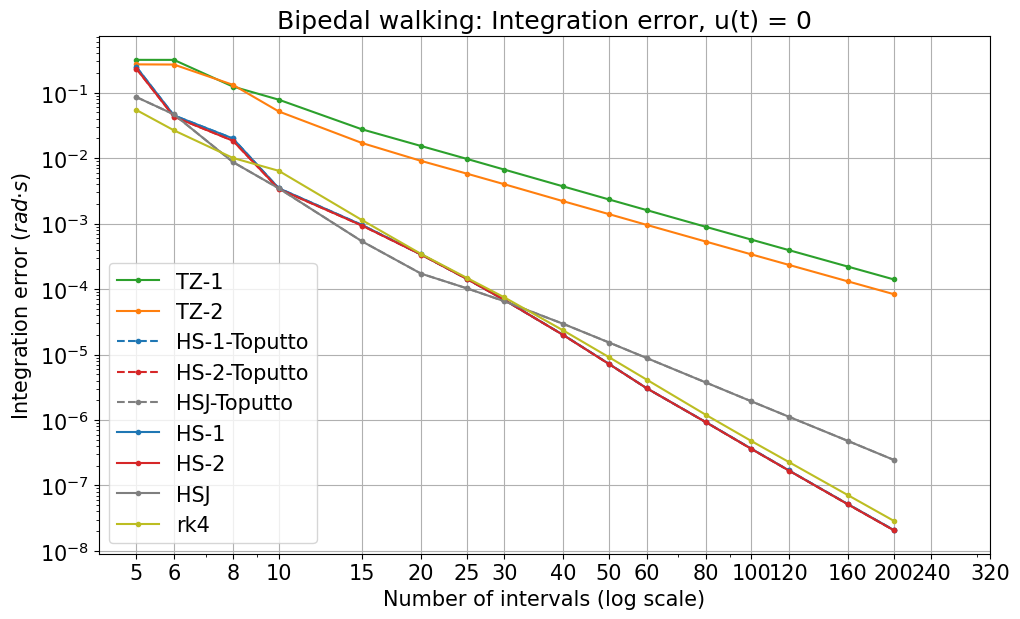

In [164]:
schemes_plot = ['trapz', 'trapz_mod', 'hs', 'hs_mod', 'hsj','hs_parab', 'hs_mod_parab', 'hsj_parab', 'rk4']
plt.figure(figsize=oct_fig_size)
for key in schemes_plot:
    plt.plot(integ_results_zero[key]['N_arr'],
             integ_results_zero[key]['error_sum'],
             ms = 3,
             **scheme_kwargs(key, longlabel=False))
plt.grid()
plt.legend()
plt.yscale('log')
plt.xscale('log')
#ticks = np.array(integ_results[key]['N_arr'][::])
ticks = np.array([5, 6, 8, 10, 15, 20, 25, 30, 40, 50, 60, 80, 100, 120, 160, 200, 240, 320])
plt.xticks(ticks, labels=ticks)

plt.title(r'Bipedal walking: Integration error, u(t) = 0')
plt.xlabel('Number of intervals (log scale)')
plt.ylabel('Integration error ($rad·s$)')
plt.tight_layout(pad = 0.0)
#plt.savefig('hsj_pics/5_link_integration_error_u_0_vs_interval_number.eps', format='eps')

### Saving Results

In [126]:
# Save results
with open('biped_results_common_u_zero.pkl', 'wb') as f:
    pickle.dump(integ_results_zero, f)


## Animation

In [ ]:
from matplotlib import animation, rc
import matplotlib.patches as patches
from matplotlib.transforms import Affine2D
from IPython.display import HTML

In [ ]:
matplotlib.rcParams['animation.embed_limit'] = 200

In [ ]:
def body_tray(X, params):
    res = []
    for ii in range(X.shape[0]):
        res.append(list(chain_to_draw(X[ii,:], params)))
    return np.array(res)

In [ ]:
def loop_body_tray(X, params):
    point_tray = body_tray(X, params)
    point_tray_loop = np.append(
        point_tray,
        np.expand_dims(
            np.array(list(chain_to_draw(X[0,[4,3,2,1,0,5,6,7,8,9]],params)))
            ,0),
        0)
    return point_tray_loop

In [ ]:
def create_anim(X, U, params, n_loops = 1):
    [
    I_0_n, I_1_n, I_2_n, I_3_n, I_4_n,
    d_0_n, d_1_n, d_2_n, d_3_n, d_4_n,
    g_n,
    l_0_n, l_1_n, l_3_n,
    m_0_n, m_1_n, m_2_n, m_3_n, m_4_n
    ] = params
    
    N = X.shape[0]
    fig, ax = plt.subplots()
    draw_width = 14
    draw_height = 14
    
    fig.set_dpi(300)
    fig.set_size_inches([draw_width,draw_height])
    ax.set_xlim(( -1, 1))
    ax.set_ylim(( -0.2, 1.8))
    
    body, = ax.plot([], [], lw=4, ms = 12, marker = 'o')
    trail, = ax.plot([], [], lw=1, color = 'k')
    old_trail, = ax.plot([], [], lw=1, color = 'k')
    next_trail, = ax.plot([], [], lw=1, color = 'k')
    
    
    point_tray = body_tray(X, params)
    point_tray_loop = loop_body_tray(X, params)
    #sys_cm_point, = ax.plot([], [], 'go', ms=12)
    #line_sys_cm, = ax.plot([], [], 'k:', lw=1)
    
    print_vars = [X[:,ii] for ii in range(5)]+[np.linspace(0, N-1, N, dtype=int)]
    print_var_names = [f'q_{ii}' for ii in range(5)]+['step']
    texts = []
    ii = 0.8
    for arr in print_vars:
        texts.append(ax.text(-0.8, ii, "", fontsize = 12))
        ii -= 0.2
    
    ax.grid()
    
    def init():
        body.set_data([], [])
        trail.set_data(point_tray_loop[0,0,-1], point_tray_loop[0,1,-1])
        old_trail.set_data(point_tray_loop[:,0,-1]-0.5, point_tray_loop[:,1,-1])
        #next_trail.set_data(point_tray_loop[:,0,-1]+0.5, point_tray_loop[:,1,-1])
        #sys_cm_point.set_data([], [])
        #line_sys_cm.set_data([], [])
        return (body,)
    
    def animate(i):
        margin_x = -0.25 + i * 0.5/N
        trail.set_data(point_tray_loop[0:i+1,0,-1], point_tray_loop[0:i+1,1,-1])
        #sys_cm_coords = sys_cm_np(X[i,:], params)
        #sys_cm_point.set_data(sys_cm_coords)
        #line_sys_cm.set_data([0, sys_cm_coords[0]], [0, sys_cm_coords[1]])
        
        ax.set_xlim(( -1+ margin_x, 1+ margin_x))
        points_x, points_y = point_tray[i,:,:]
        body.set_data(points_x, points_y) 
        
        for ii in range(len(texts)):
            text = texts[ii]
            name = print_var_names[ii]
            arr = print_vars[ii]
            text.set_position((-0.9 + margin_x, 1.7 - 0.05*ii))
            if name == 'step':
                text.set_text("$step$ = " + str(arr[i]))
            else:
                text.set_text("$" + name + "$ = %.3f" % arr[i])
        return (body,)
    iterable_frames = sum([[jj for jj in range(N)]for kk in range(n_loops)], start = [])
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=iterable_frames, interval=20, 
                               blit=True)
    return anim





In [ ]:
anim = create_anim(results['hs_mod_parab'][25]['x'][:-1,:],results['hs_mod_parab'][25]['u'], params, 20)

In [ ]:
HTML(anim.to_jshtml())

In [ ]:
f = r"biped_animation_hd.mp4" 
writervideo = animation.FFMpegWriter(fps=25//0.7) 
anim.save(f, writer=writervideo)

In [ ]:
def __create_anim_simp(X, U, params):
    [
    I_0_n, I_1_n, I_2_n, I_3_n, I_4_n,
    d_0_n, d_1_n, d_2_n, d_3_n, d_4_n,
    g_n,
    l_0_n, l_1_n, l_3_n,
    m_0_n, m_1_n, m_2_n, m_3_n, m_4_n
    ] = params
    
    N = X.shape[0]
    fig, ax = plt.subplots()
    
    y_scale = 1
    min_x_cart = np.min(X[:,0])
    max_x_cart = np.max(X[:,0])
    cart_displ = max_x_cart-min_x_cart
    size_x = 2*y_scale + cart_displ
    size_y = 2*y_scale
    draw_width = 14
    draw_height = draw_width / size_x * size_y
    
    x_0 = X[:,0]
    y_0 = np.zeros_like(x_0)
    x_1 = x_0 + l_3*np.sin(X[:,1])
    y_1 = y_0 - l_3*np.cos(X[:,1])
    
    x_cm = (m_0 * x_0 + m_2 * x_1)/(m_0 + m_2)
    y_cm = (m_0 * y_0 + m_2 * y_1)/(m_0 + m_2)

    fig.set_size_inches([draw_width,draw_height])
    ax.set_xlim(( min_x_cart-y_scale, max_x_cart+y_scale))
    ax.set_ylim(( -y_scale, y_scale))

    circle1 = plt.Circle((0, 0), l_3, color='b', ls = ":", fill=False)
    ax.add_artist(circle1)
    ax.plot([min_x_cart - l_3, max_x_cart + l_3], [0,0], 'k', lw=1, ls = ':')

    line1, = ax.plot([], [], lw=2)
    line3, = ax.plot([], [], 'k', lw=1, ls = ':')
    line_cm, = ax.plot([], [], 'g', lw=1, ls = ':')
    point0, = ax.plot([], [], marker='o', markersize=15, color="red")
    point1, = ax.plot([], [], marker='o', markersize=15, color="red")
    point_cm, = ax.plot([], [], marker='o', markersize=10, color="green")
    u_max = max(np.max(np.abs(U[:,0])),1e-15)
    arrow_w = 0.05*l_3
    arrow_l = 0.2*l_3
    u_arrow = patches.Arrow(0, 0, 0, -arrow_l, color = 'gray',width = arrow_w)
    ax.add_patch(u_arrow)
    
    print_vars = [X[:,0], X[:,1], U[:,0], U[:,1], np.linspace(0, N-1, N, dtype=int)]
    print_var_names = ['q_0', 'q_1', 'u_0', 'u_1', 'step']
    texts = []
    ii = 0
    for arr in print_vars:
        texts.append(ax.text(0.2, ii, "", fontsize = 12))
        ii -= 0.08*l_3
    
    def init():
        line1.set_data([], [])
        line3.set_data([], [])
        line_cm.set_data([], [])
        point1.set_data([], [])
        circle1.center = (0, 0)
        return (line1,)
    def animate(i):
        circle1.center = (x_0[i], y_0[i])
        point0.set_data(x_0[i], y_0[i])
        line1.set_data([x_0[i], x_1[i]], [y_0[i], y_1[i]])    
        point1.set_data(x_1[i], y_1[i])
        point_cm.set_data(x_cm[i], y_cm[i])
        line3.set_data(x_1[:i], y_1[:i])
        line_cm.set_data(x_cm[:i], y_cm[:i])
        trans = Affine2D()
        u_arrow._patch_transform = trans.scale(U[i,0] * arrow_l / u_max, arrow_w).translate(x_0[i],0)
        for ii in range(len(texts)):
            text = texts[ii]
            name = print_var_names[ii]
            arr = print_vars[ii]
            text.set_text("$" + name + "$ = %.6f" % arr[i])
        return (line1,u_arrow)
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=N, interval=20, 
                               blit=True)
    return anim